## ⚙️ Import Libraries

### Parallel Dual Unet - Multi Dynamic Loss - Usage of Transformer
excluded label 0 from all losses\
one-hot encoding only for dice and boundary\
custom dice (for excluding the label 0)\
increased the U1 filters\

In [1]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

from datetime import datetime

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as L
from tensorflow.keras import ops
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Import other libraries
import os
import math
from PIL import Image
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.utils import class_weight

import seaborn as sns
import pandas as pd

import hashlib
from collections import defaultdict
import matplotlib.pyplot as plt

import keras_hub as kh

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")

TensorFlow version: 2.16.1
Keras version: 3.3.3
GPU devices: 2


## ⏳ Load

In [2]:
data = np.load("/kaggle/input/mars-training-set/mars_for_students.npz")

training_set = data["training_set"]
X_train_val = training_set[:, 0]
y_train_val = training_set[:, 1]

X_test = data["test_set"]

input_shape = X_train_val.shape[1:]
NUM_CLASSES = len(np.unique(y_train_val))

print(f"\nInput shape: {input_shape}")
print(f"Number of classes: {NUM_CLASSES}")

print(f"\nShape of X_train: {X_train_val.shape}")
print(f"Shape of y_train: {y_train_val.shape}")
print(f"Shape of X_test: {X_test.shape}")


Input shape: (64, 128)
Number of classes: 5

Shape of X_train: (2615, 64, 128)
Shape of y_train: (2615, 64, 128)
Shape of X_test: (10022, 64, 128)


# Inspect Images

Training set images: 2615


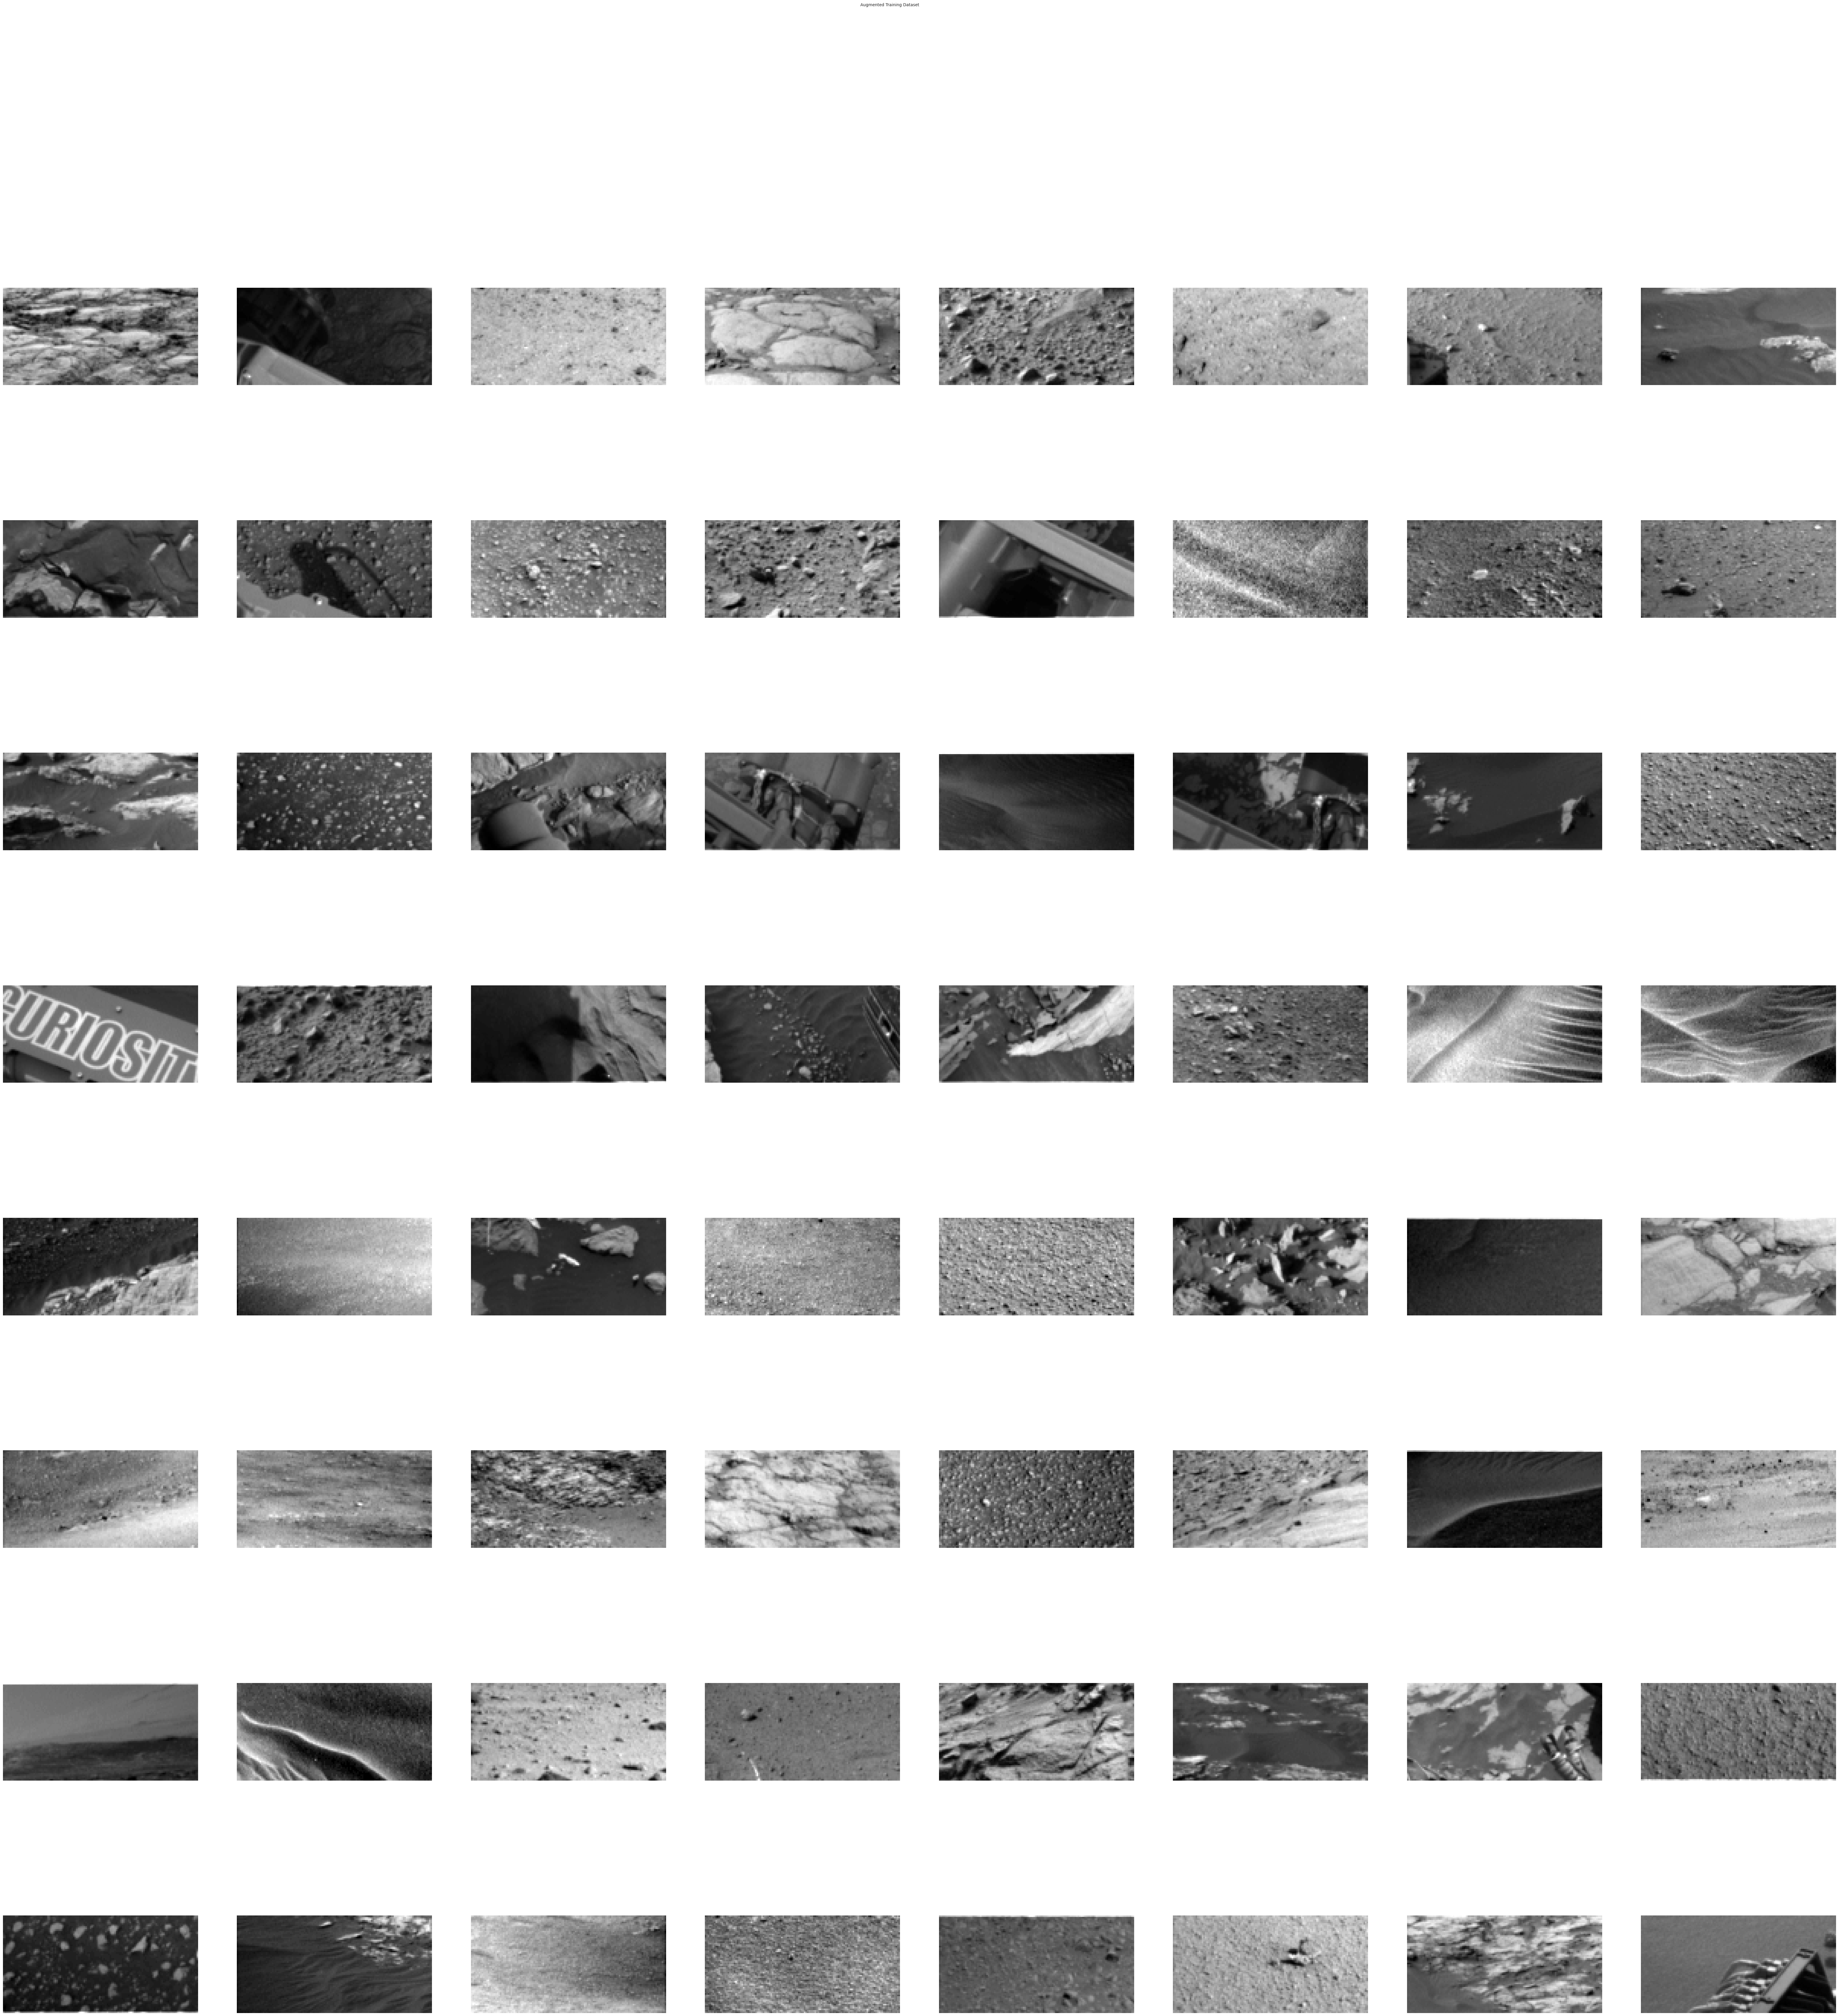

In [3]:
def visualize_dataset(dataset, title, image_size=(10, 10), grid_size=(8, 8)):
    print("Training set images:", len(dataset))

    num_images_to_plot = grid_size[0] * grid_size[1]
    random_indices = random.sample(range(len(dataset)), num_images_to_plot)
    sampled_images = [dataset[i] for i in random_indices]
    
    figsize = (grid_size[1] * image_size[0], grid_size[0] * image_size[1])
    plt.figure(figsize=figsize)
    plt.suptitle(title, fontsize=10)
    for i, image in enumerate(sampled_images):
        plt.subplot(grid_size[0], grid_size[1], i + 1)
        plt.imshow(image, cmap="gray")  # Grayscale visualization
        plt.axis("off")
    plt.show()

visualize_dataset(X_train_val, "Augmented Training Dataset")

## 👽 Detect Outliers

In [4]:
# Function to calculate the hash of an image
def calculate_image_hash(image):
    return hashlib.md5(image.tobytes()).hexdigest()

# Calculate hashes for each image and store their indices
hash_dict = defaultdict(list)
for idx, image in enumerate(y_train_val):
    img_hash = calculate_image_hash(image)
    hash_dict[img_hash].append(idx)

Duplicate images found!


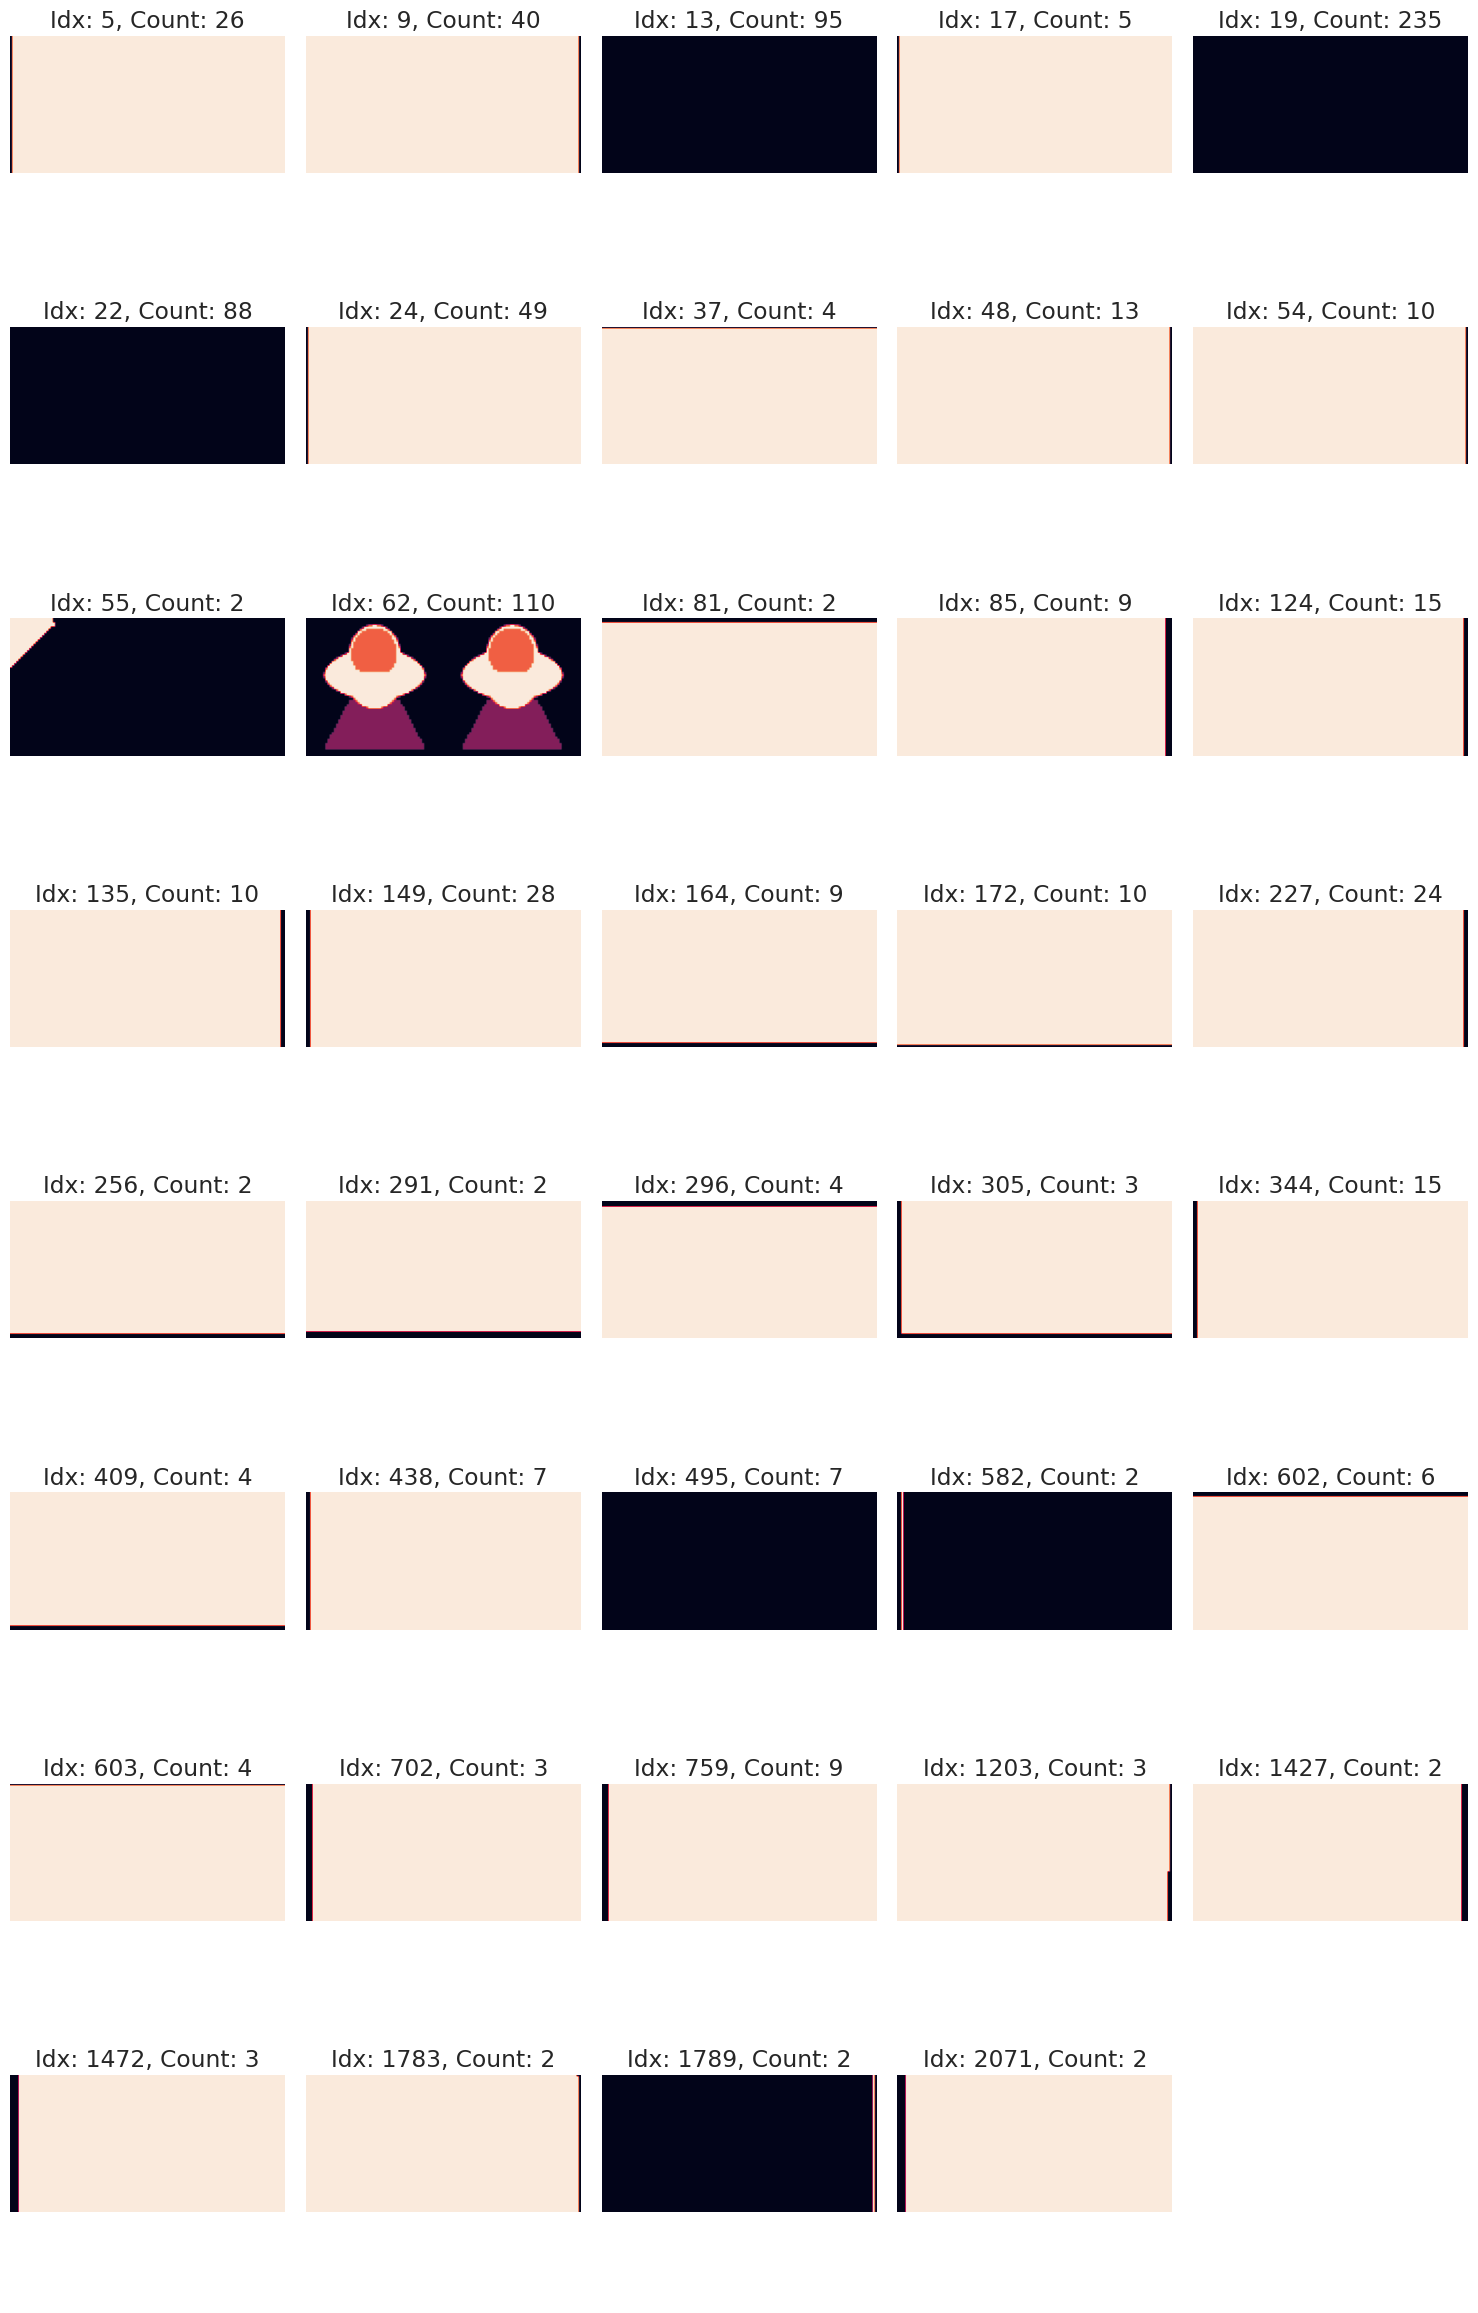

In [5]:
# Find duplicates
duplicates = {key: indices for key, indices in hash_dict.items() if len(indices) > 1}

if duplicates:
    print("Duplicate images found!")
   
    num_duplicates = len(duplicates)
    cols = 5 
    rows = (num_duplicates + cols - 1) // cols  
    
    # Create the figure and subplots
    fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))
    axes = axes.flatten()  
    
    for i, (img_hash, indices) in enumerate(duplicates.items()):
        # Select one representative image
        representative_idx = indices[0]
        occurrence_count = len(indices)  
        ax = axes[i]
        
        # Plot the image
        ax.imshow(y_train_val[representative_idx])
        
        # Set title with hash, occurrences, and first index
        ax.set_title(f"Idx: {representative_idx}, Count: {occurrence_count}")
        ax.axis('off')
    
    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()

else:
    print("No duplicate images found!")

## Inspect an index

In [6]:
def create_segmentation_colormap(num_classes):
    return plt.cm.viridis(np.linspace(0, 1, num_classes))

In [7]:
def apply_colormap(label, colormap=None):
    
    # Ensure label is 2D
    label = np.squeeze(label)

    # Ensure label values are in the valid range [0, num_classes-1]
    num_classes = len(colormap)  # Get the number of classes from the colormap
    label = np.clip(label, 0, num_classes - 1)  # Clip values to be within range

    # Apply the colormap
    colored = colormap[label.astype(int)]

    return colored

Hash for image at index 2071: 17fec901f6ed4082a70668bf7a334b37


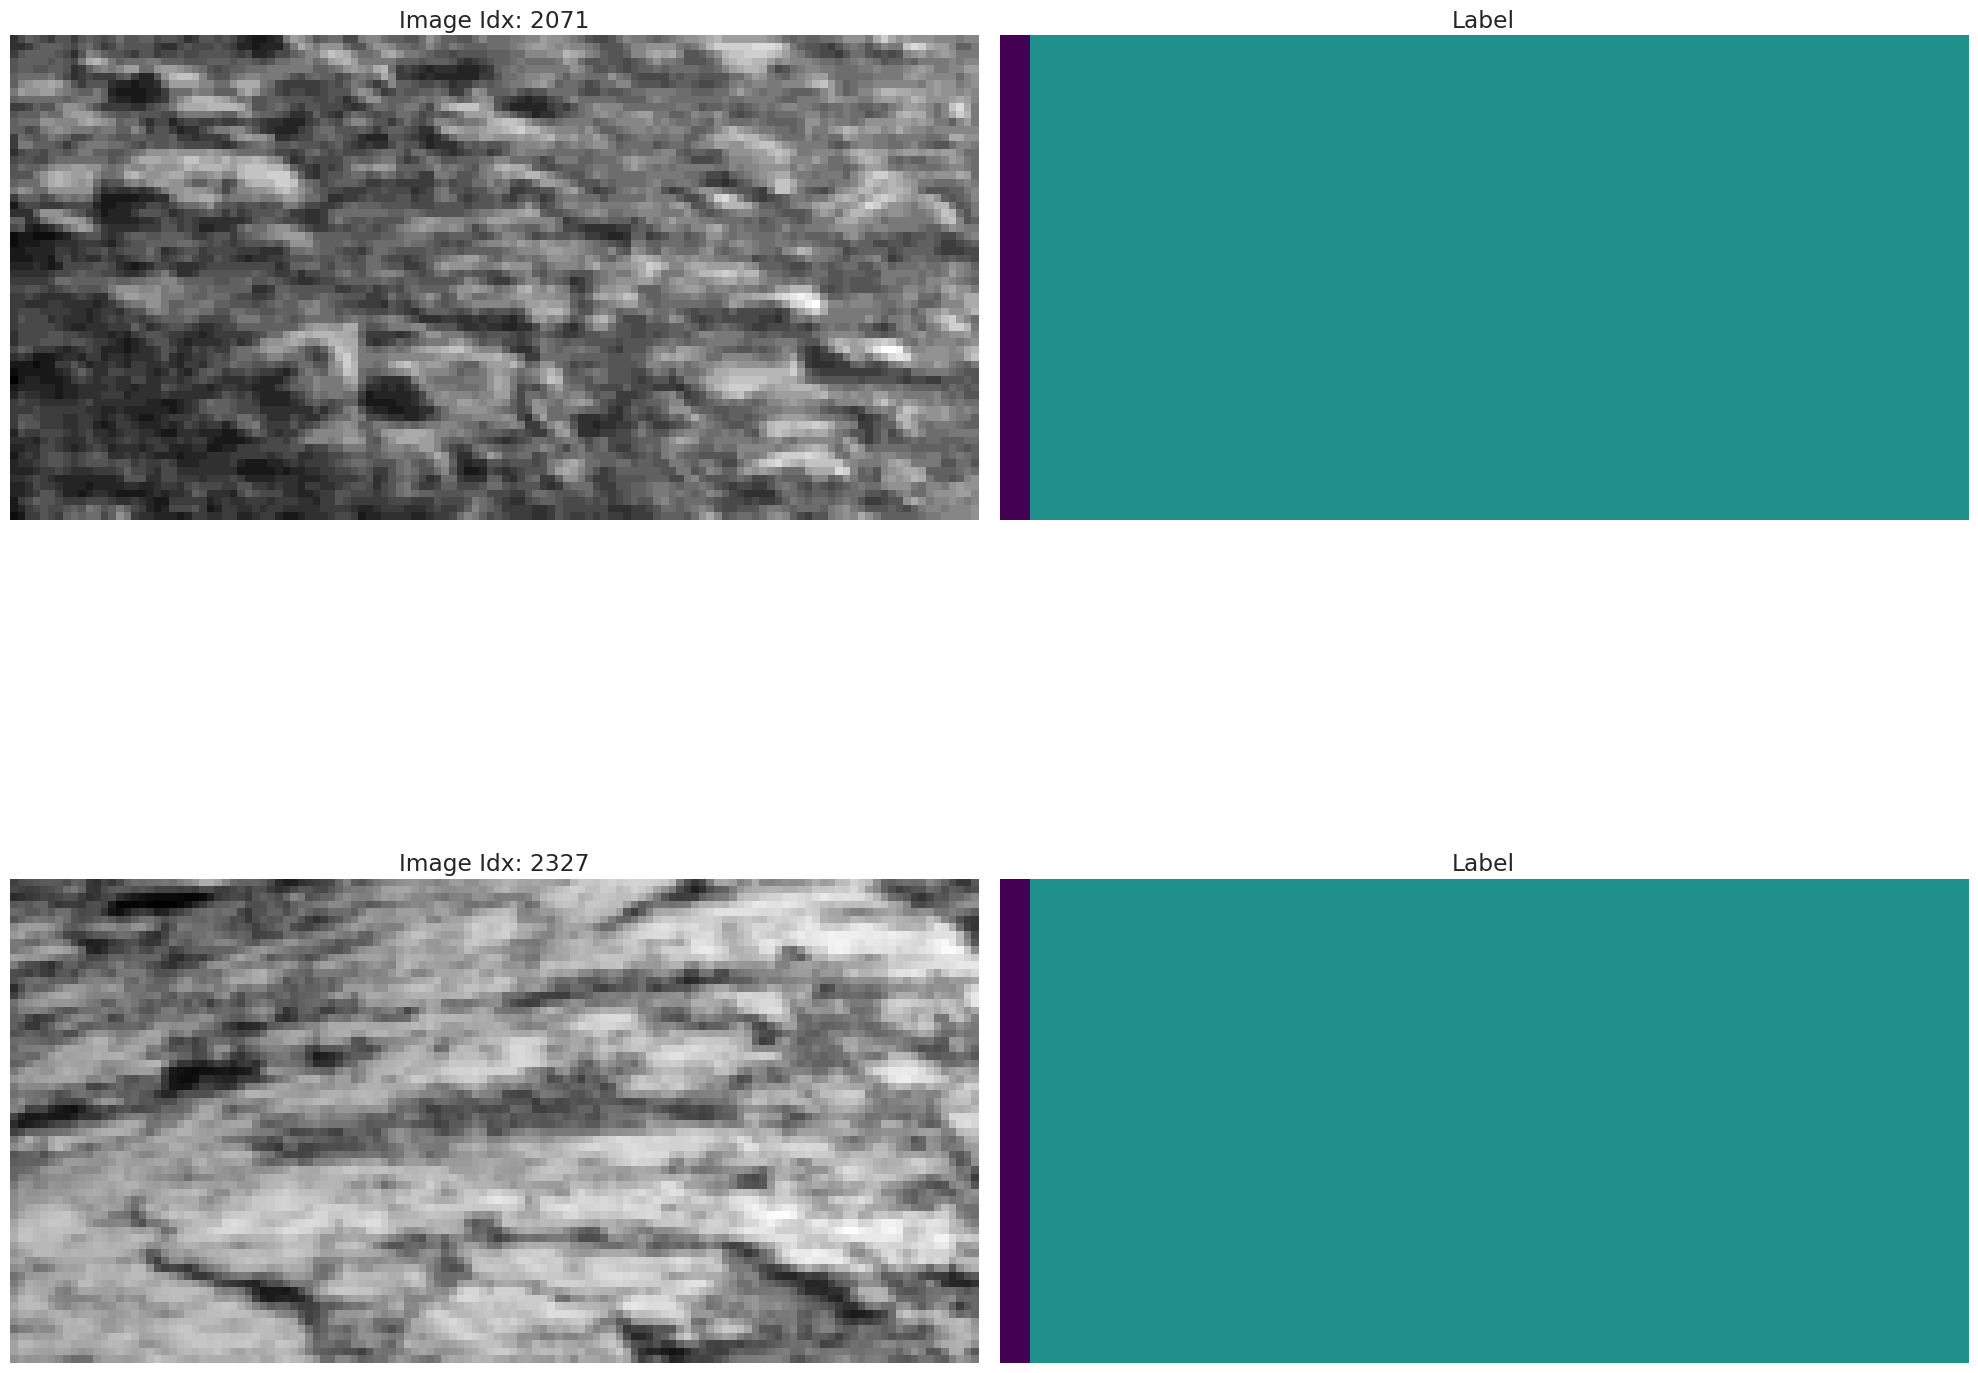

In [8]:
index_of_interest = 2071

# Function to get images associated with a specific index
def get_images_by_index(index):
    img_hash = calculate_image_hash(y_train_val[index])  # Calculate hash
    associated_indices = hash_dict.get(img_hash, [])  # Get duplicate indices
    return img_hash, associated_indices

# Get images and duplicates
img_hash, associated_indices = get_images_by_index(index_of_interest)

if associated_indices:
    print(f"Hash for image at index {index_of_interest}: {img_hash}")
    
    num_images = len(associated_indices)
    cols = 2  # Show image and label side-by-side
    rows = num_images  # One row per image-label pair
    
    # Create colormap for labels
    num_classes = len(np.unique(y_train_val))
    colormap = create_segmentation_colormap(num_classes)

    # Larger figure size for better visuals
    fig, axes = plt.subplots(rows, cols, figsize=(20, 10 * rows))
    axes = axes.reshape(rows, cols)  # Ensure axes is 2D for easy access

    for i, idx in enumerate(associated_indices):
        # Plot the image
        ax_image = axes[i, 0]
        ax_image.imshow(X_train_val[idx], cmap='gray' if X_train_val[idx].ndim == 2 else None)
        ax_image.set_title(f"Image Idx: {idx}")
        ax_image.axis('off')

        # Plot the label
        ax_label = axes[i, 1]
        colored_label = apply_colormap(y_train_val[idx], colormap)
        ax_label.imshow(colored_label)
        ax_label.set_title("Label")
        ax_label.axis('off')


    plt.subplots_adjust(wspace=0.4, hspace=0.4)  # Adjust spacing
    plt.tight_layout()
    plt.show()

else:
    print(f"No duplicates found for image at index {index_of_interest}.")


In [9]:
alien_index = 62

# Get associated indices
img_hash, alin_associated_indices = get_images_by_index(alien_index)

if(X_train_val.shape[0] == 2615):
    X_train_val = np.delete(X_train_val, alin_associated_indices, axis=0)
    y_train_val = np.delete(y_train_val, alin_associated_indices, axis=0)
    print("Outliers removed")
else:
    print("Outliers already removed")

print("Dataset dimension:", X_train_val.shape)

Outliers removed
Dataset dimension: (2505, 64, 128)


## 🔄 Process Data

In [10]:
# Set batch size for training
BATCH_SIZE = 64

# Set learning rate for the optimiser
LEARNING_RATE = 1e-3

# Set early stopping patience threshold
PATIENCE = 50

# Set maximum number of training epochs
EPOCHS = 200

# Set data split size for training and validation
SPLITS_SIZE = 0.2

## dividing in train and validaiton set

In [11]:
# Split the training set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=SPLITS_SIZE, random_state=seed
)

# Display dataset information
print(f"\nNumber of images:")
print(f"Training set: {len(X_train)}")
print(f"Validation set: {len(X_val)}")
print(f"Test set: {len(X_test)}")


Number of images:
Training set: 2004
Validation set: 501
Test set: 10022


In [12]:
# Define the category mapping
category_map = {
        0: 0,  # background
        1: 1,  # soil
        2: 2,  # bedrock
        3: 3,  # sand
        4: 4   # big rock
}

# Define the classes 
classes = ['background', 'soil', 'bedrock', 'sand', 'big rock'] 

NUM_CLASSES = len(set(category_map.values()))
print(f"Number of categories: {len(category_map)}")

Number of categories: 5


## normalizing the data

In [13]:
def preprocess_data(X, y, input_size=(64, 128)):
    X = tf.expand_dims(X, axis=-1)  
    X = tf.image.resize(X, input_size)
    X = tf.cast(X, tf.float32) / 255.0

    y = tf.expand_dims(y, axis=-1)
    y = tf.image.resize(y, input_size, method='bilinear')
    y = tf.cast(y, tf.int32)
    return X, y

# preprocessing also the test set
X_test = X_test[..., np.newaxis] / 255.0

In [14]:
def apply_category_mapping(label):
    """
    Apply category mapping to labels.
    """
    keys_tensor = tf.constant(list(category_map.keys()), dtype=tf.int32)
    vals_tensor = tf.constant(list(category_map.values()), dtype=tf.int32)
    table = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(keys_tensor, vals_tensor),
        default_value=0
    )
    return table.lookup(label)

## defining augmentation

In [15]:
# Define augmentation
@tf.function
def random_flip(image, label, seed=None):
    """Consistent random horizontal flip."""
    if seed is None:
        seed = np.random.randint(0, 1000000)
    flip_prob = tf.random.uniform([], seed=seed)
    image = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(image),
        lambda: image
    )
    label = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(label),
        lambda: label
    )
    return image, label


In [16]:
def make_dataset(X, y, batch_size, shuffle=True, augment=False, seed=None):
    """
    Create a TensorFlow dataset. 
    """
    # Create dataset from file paths
    dataset = tf.data.Dataset.from_tensor_slices((X, y))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=batch_size * 2, seed=seed)

    # Preprocess immages and labels
    dataset = dataset.map(
        preprocess_data,
        num_parallel_calls=tf.data.AUTOTUNE
    )
    
    # Apply category mapping: change the labels
    dataset = dataset.map(
        lambda x, y: (x, apply_category_mapping(y)),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    if augment: #apply random flip
        dataset = dataset.map(
            lambda x, y: random_flip(x, y, seed=seed),
            num_parallel_calls=tf.data.AUTOTUNE
        )

    # Batch the data (do it now and not at training time)
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

In [17]:
# Create the datasets
train_dataset = make_dataset(
    X_train, y_train, 
    batch_size=BATCH_SIZE,
    shuffle=True,
    augment=True,
    seed=seed
)

val_dataset = make_dataset(
    X_val, y_val,
    batch_size=BATCH_SIZE,
    shuffle=False 
)

# Check the shape of the data
for images, labels in train_dataset.take(1):
    INPUT_SHAPE = images.shape[1:]
    print(f"\nInput shape: {INPUT_SHAPE}")
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    print("Labels dtype:", labels.dtype)
    break


Input shape: (64, 128, 1)
Images shape: (64, 64, 128, 1)
Labels shape: (64, 64, 128, 1)
Labels dtype: <dtype: 'int32'>


Visualizing examples from the training set:


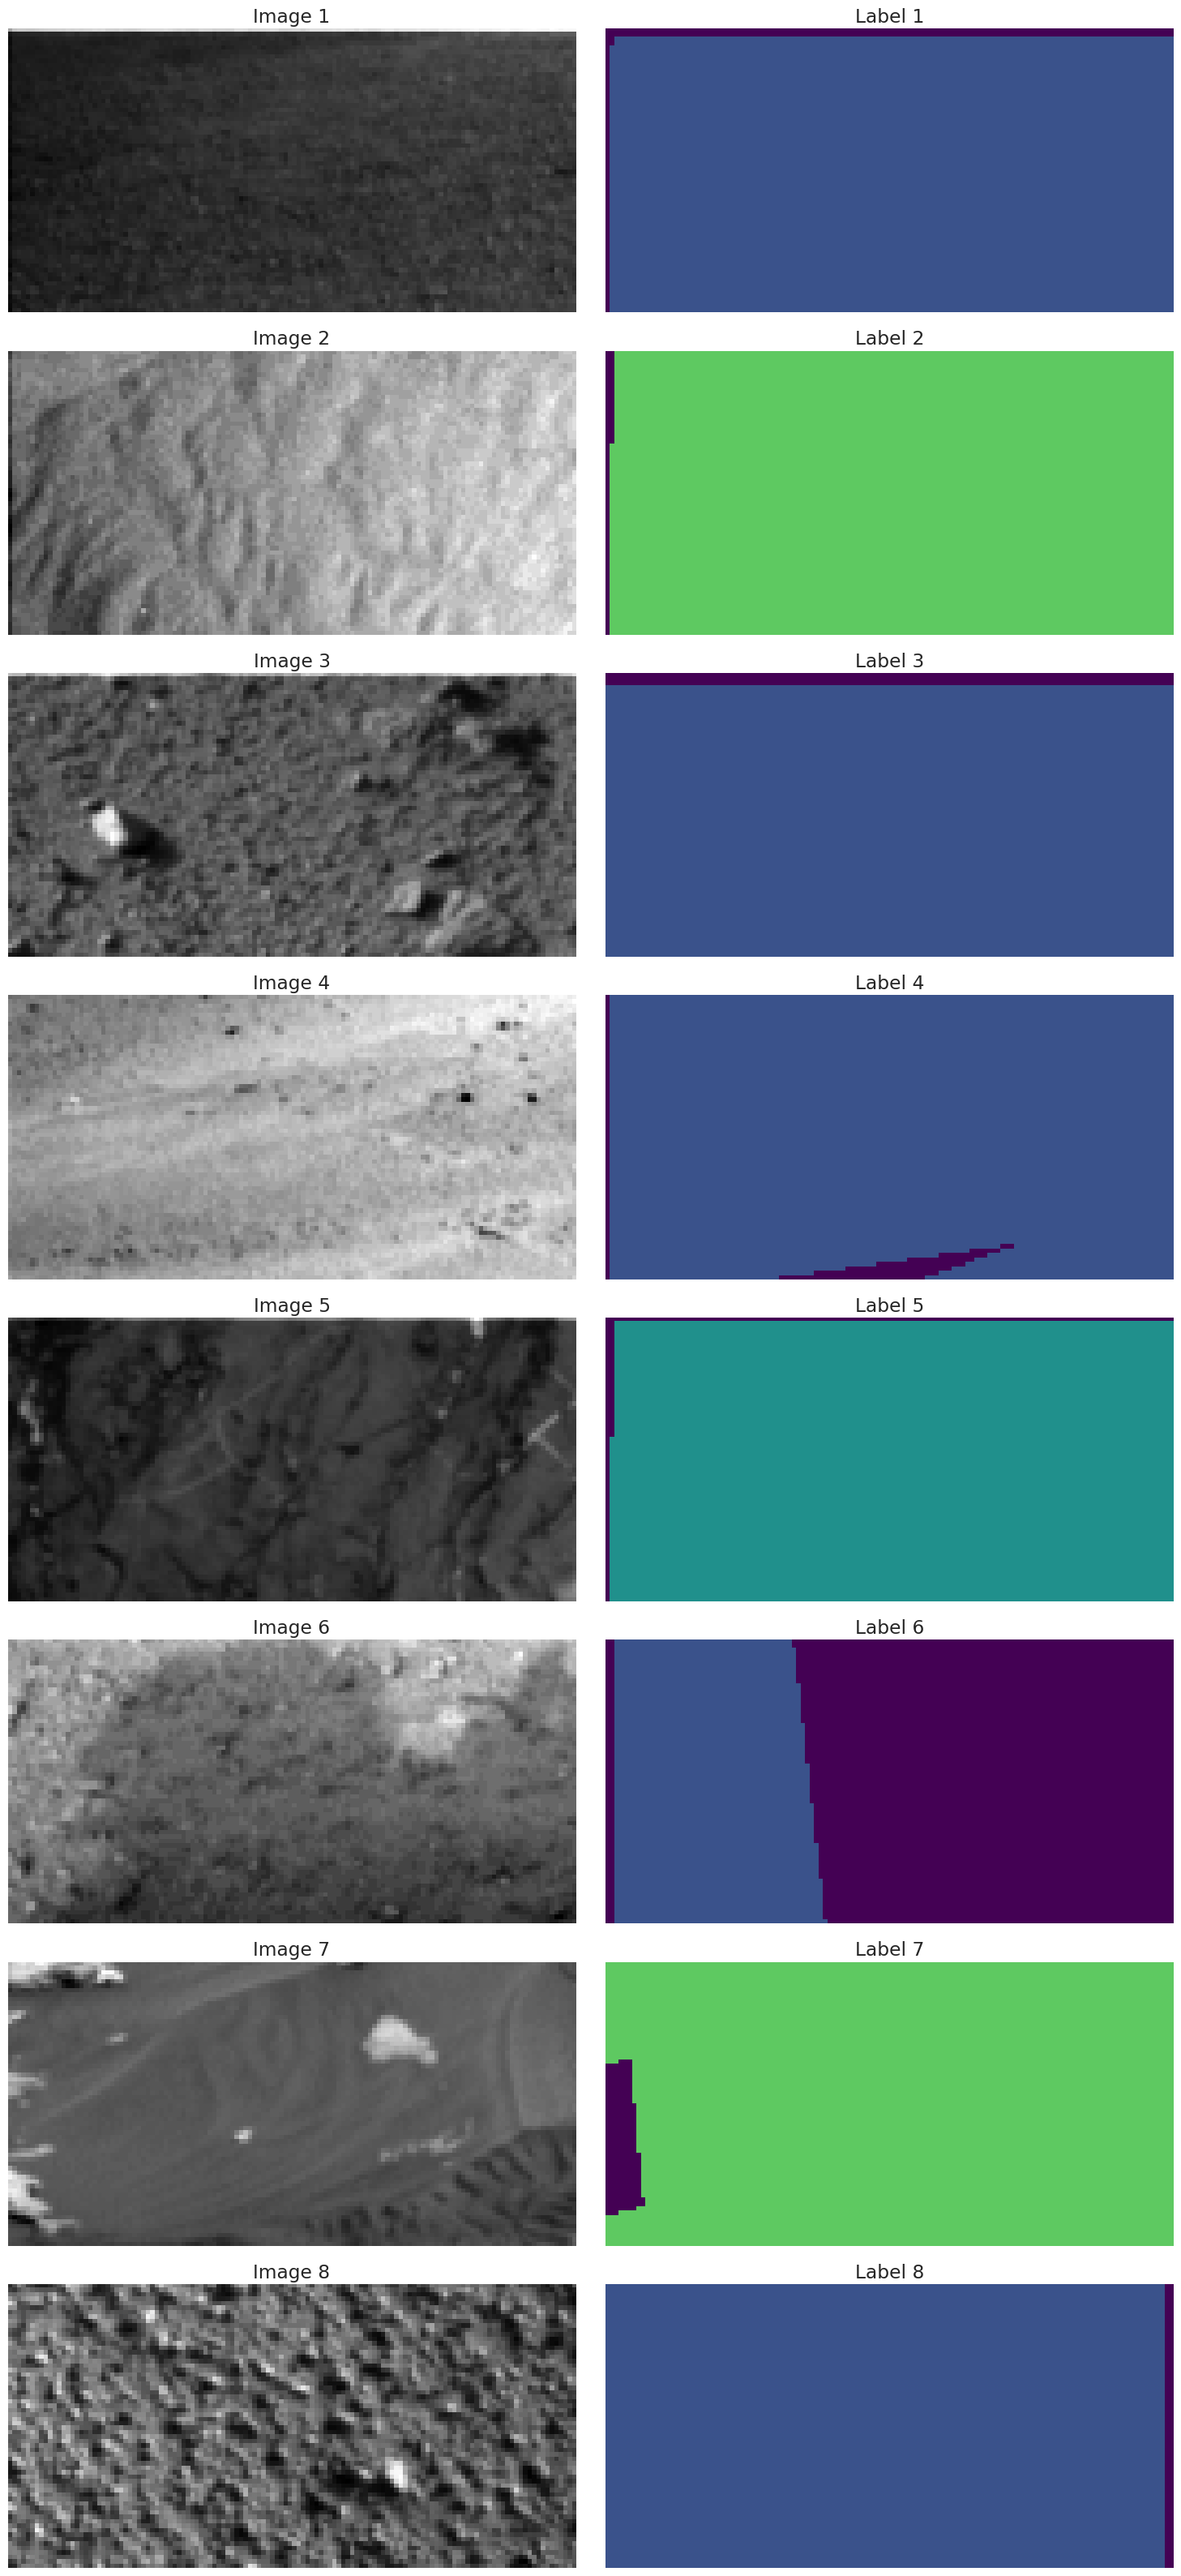

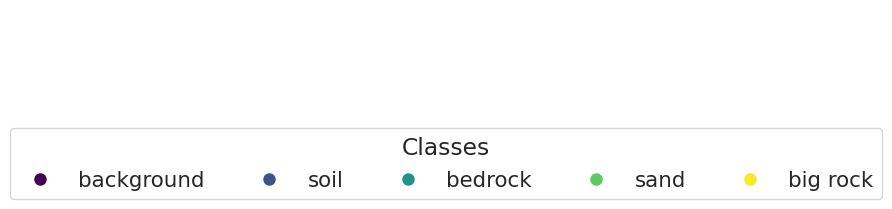

In [18]:
# Plot real image and ground truth (reduced resolution)
def plot_sample_batch(dataset, num_samples=3):
    """
    Display some image and label pairs from the dataset.
    """
    plt.figure(figsize=(15, 4 * num_samples))

    for images, labels in dataset.take(1):
        labels_np = labels.numpy()
        num_classes = len(category_map)  # Ensure colormap covers all classes, including the background
        colormap = create_segmentation_colormap(num_classes)

        for j in range(min(num_samples, len(images))):
            # Plot original grayscale image (no colormap)
            plt.subplot(num_samples, 2, j * 2 + 1)
            plt.imshow(images[j], cmap='gray')  # Use 'gray' cmap for the images (ensure grayscale)
            plt.title(f'Image {j + 1}')
            plt.axis('off')

            # Plot colored label (apply colormap only to labels)
            plt.subplot(num_samples, 2, j * 2 + 2)
            colored_label = apply_colormap(labels_np[j], colormap)  # Apply colormap to the labels only
            plt.imshow(colored_label)  # Show the colored label
            plt.title(f'Label {j + 1}')
            plt.axis('off')

    plt.tight_layout()
    plt.show()
    plt.close()

    handles = []
    # After all images have been plotted, add the legend once
    for label_idx in category_map:
        color = colormap[label_idx]  # Use array indexing, subtracting 1 to account for class 0 exclusion
        handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=classes[label_idx]))
    
    # Create a single legend displayed at the bottom
    fig, ax = plt.subplots(figsize=(10, 2))  # Make the figure wide enough for a horizontal legend
    ax.legend(handles=handles, loc='center', bbox_to_anchor=(0.5, 0), title="Classes", ncol=len(category_map))
    ax.axis('off')
    plt.show()

# Visualize examples from the training set
print("Visualizing examples from the training set:")
plot_sample_batch(train_dataset, num_samples=8)

## 🛠️ Model Definition and Training

In [19]:
def conv_block(x, num_filters, act=True):
    x = L.Conv2D(num_filters, kernel_size=3, padding="same")(x)

    if act == True:
        x = L.BatchNormalization()(x)
        x = L.Activation("relu")(x)

    return x

def encoder_block(x, num_filters):
    x = conv_block(x, num_filters)
    x = conv_block(x, num_filters)

    p = L.MaxPool2D((2, 2))(x)
    return x, p

In [20]:
def unet3plus(input_shape, num_classes):
    """ Inputs """
    inputs = L.Input(input_shape, name="input_layer")

    """ Encoder """
    e1, p1 = encoder_block(inputs, 64)
    e2, p2 = encoder_block(p1, 128)
    e3, p3 = encoder_block(p2, 256)
    e4, p4 = encoder_block(p3, 512)

    """ Bottleneck """
    e5 = conv_block(p4, 1024)
    e5 = conv_block(e5, 1024)

    """ Decoder 4 """
    e1_d4 = L.MaxPool2D((8, 8))(e1)
    e1_d4 = conv_block(e1_d4, 64)

    e2_d4 = L.MaxPool2D((4, 4))(e2)
    e2_d4 = conv_block(e2_d4, 64)

    e3_d4 = L.MaxPool2D((2, 2))(e3)
    e3_d4 = conv_block(e3_d4, 64)

    e4_d4 = conv_block(e4, 64)

    e5_d4 = L.UpSampling2D((2, 2), interpolation="bilinear")(e5)
    e5_d4 = conv_block(e5_d4, 64)

    d4 = L.Concatenate()([e1_d4, e2_d4, e3_d4, e4_d4, e5_d4])
    d4 = conv_block(d4, 64*5)

    """ Decoder 3 """ #8000F8
    e1_d3 = L.MaxPool2D((4, 4))(e1)
    e1_d3 = conv_block(e1_d3, 64)

    e2_d3 = L.MaxPool2D((2, 2))(e2)
    e2_d3 = conv_block(e2_d3, 64)

    e3_d3 = conv_block(e3, 64)

    d4_d3 = L.UpSampling2D((2, 2), interpolation="bilinear")(d4)
    d4_d3 = conv_block(d4_d3, 64)

    e5_d3 = L.UpSampling2D((4, 4), interpolation="bilinear")(e5)
    e5_d3 = conv_block(e5_d3, 64)

    d3 = L.Concatenate()([e1_d3, e2_d3, e3_d3, d4_d3, e5_d3])
    d3 = conv_block(d3, 64*5)

    """ Decoder 2 """
    e1_d2 = L.MaxPool2D((2, 2))(e1)
    e1_d2 = conv_block(e1_d2, 64)

    e2_d2 = conv_block(e2, 64)

    d3_d2 = L.UpSampling2D((2, 2), interpolation="bilinear")(d3)
    d3_d2 = conv_block(d3_d2, 64)

    d4_d2 = L.UpSampling2D((4, 4), interpolation="bilinear")(d4)
    d4_d2 = conv_block(d4_d2, 64)

    e5_d2 = L.UpSampling2D((8, 8), interpolation="bilinear")(e5)
    e5_d2 = conv_block(e5_d2, 64)

    d2 = L.Concatenate()([e1_d2, e2_d2, d3_d2, d4_d2, e5_d2])
    d2 = conv_block(d2, 64*5)

    """ Decoder 1 """
    e1_d1 = conv_block(e1, 64)

    d2_d1 = L.UpSampling2D((2, 2), interpolation="bilinear")(d2)
    d2_d1 = conv_block(d2_d1, 64)

    d3_d1 = L.UpSampling2D((4, 4), interpolation="bilinear")(d3)
    d3_d1 = conv_block(d3_d1, 64)

    d4_d1 = L.UpSampling2D((8, 8), interpolation="bilinear")(d4)
    d4_d1 = conv_block(d4_d1, 64)

    e5_d1 = L.UpSampling2D((16, 16), interpolation="bilinear")(e5)
    e5_d1 = conv_block(e5_d1, 64)

    d1 = L.Concatenate()([e1_d1, d2_d1, d3_d1, d4_d1, e5_d1])
    d1 = conv_block(d1, 64*5)

    """ Output """
    y1 = L.Conv2D(num_classes, kernel_size=3, padding="same")(d1)
    y1 = L.Activation("sigmoid")(y1)
    outputs = [y1]

    model = tf.keras.Model(inputs, outputs, name='U-Net_3plus')
    return model

Model: "U-Net_3plus"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer       │ (None, 64, 128, │         0 │ -              │   -   │
│ (InputLayer)      │ 1)              │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d (Conv2D)   │ (None, 64, 128, │       640 │ input_layer[0… │   Y   │
│                   │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ batch_normalizat… │ (None, 64, 128, │       256 │ conv2d[0][0]   │   Y   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ activation        │ (None, 64, 128, │         0 │ batch_normali… │   -   │
│ (Activation)      │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d_1 (Conv2D) │ (None, 64, 128, │    36,928 │ activation[0]… │   Y   │
│                   │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ batch_normalizat… │ (None, 64, 128, │       256 │ conv2d_1[0][0] │   Y   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ activation_1      │ (None, 64, 128, │         0 │ batch_normali… │   -   │
│ (Activation)      │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ max_pooling2d     │ (None, 32, 64,  │         0 │ activation_1[… │   -   │
│ (MaxPooling2D)    │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d_2 (Conv2D) │ (None, 32, 64,  │    73,856 │ max_pooling2d… │   Y   │
│                   │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ batch_normalizat… │ (None, 32, 64,  │       512 │ conv2d_2[0][0] │   Y   │
│ (BatchNormalizat… │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ activation_2      │ (None, 32, 64,  │         0 │ batch_normali… │   -   │
│ (Activation)      │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d_3 (Conv2D) │ (None, 32, 64,  │   147,584 │ activation_2[… │   Y   │
│                   │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ batch_normalizat… │ (None, 32, 64,  │       512 │ conv2d_3[0][0] │   Y   │
│ (BatchNormalizat… │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ activation_3      │ (None, 32, 64,  │         0 │ batch_normali… │   -   │
│ (Activation)      │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ max_pooling2d_1   │ (None, 16, 32,  │         0 │ activation_3[… │   -   │
│ (MaxPooling2D)    │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d_4 (Conv2D) │ (None, 16, 32,  │   295,168 │ max_pooling2d… │   Y   │
│                   │ 256)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ batch_normalizat… │ (None, 16, 32,  │     1,024 │ conv2d_4[0][0] │   Y 

 Total params: 26,995,205 (102.98 MB)

 Trainable params: 26,982,149 (102.93 MB)

 Non-trainable params: 13,056 (51.00 KB)

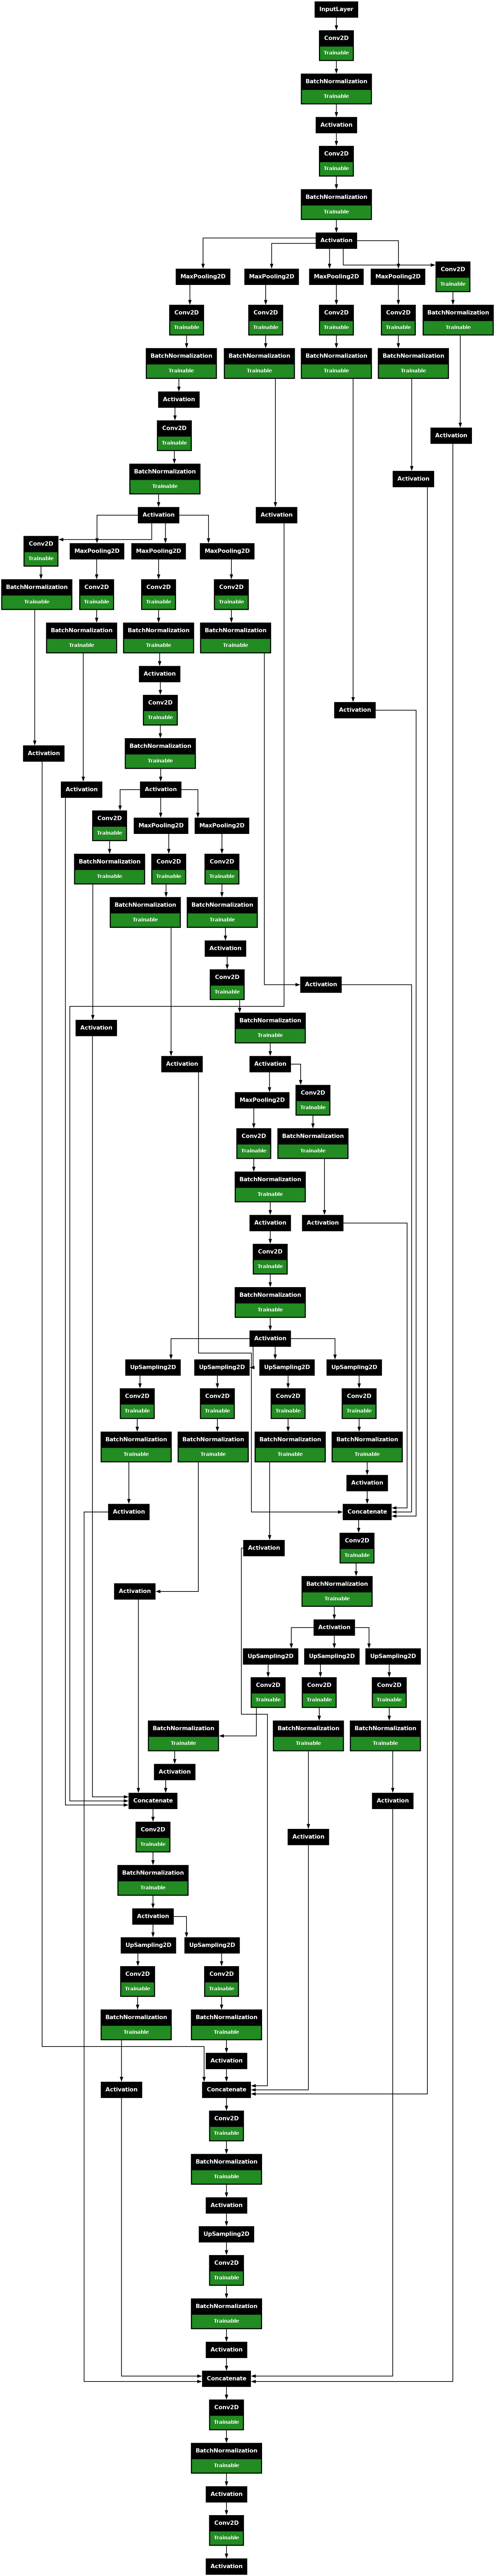

In [21]:
model = unet3plus(INPUT_SHAPE, NUM_CLASSES)

# Print a detailed summary of the model with expanded nested layers and trainable parameters.
model.summary(expand_nested=True, show_trainable=True)

# Generate and display a graphical representation of the model architecture.
tf.keras.utils.plot_model(model, expand_nested=True, show_trainable=True, dpi=70)

In [22]:
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)

# Visualization callback: plot during the training the prediction and the images
#useful for debugging ex. I'm stuck in a local minima where the less represented class is never predicted
class VizCallback(tf.keras.callbacks.Callback):
    def __init__(self, val_dataset, frequency=5):
        super().__init__()
        self.val_dataset = val_dataset  # The validation dataset
        self.frequency = frequency

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:  # Visualize only every "frequency" epochs
            # Get a batch from the validation dataset
            for image_batch, label_batch in self.val_dataset.take(1):
                for i in range(2):
                    idx = 0 if i==0 else 14
                    image = image_batch[idx]  # Take the first image from the batch (oppure 13)
                    label = label_batch[idx]  # Take the first label from the batch
    
                    # Add batch dimension to the image (if necessary)
                    image = tf.expand_dims(image, 0)
    
                    # Perform prediction
                    pred = self.model.predict(image, verbose=0)
                    y_pred = tf.math.argmax(pred, axis=-1)
                    y_pred = y_pred.numpy()  # Convert to NumPy array for visualization
    
                    # Create colormap (assuming a predefined function `create_segmentation_colormap`)
                    num_classes = NUM_CLASSES
                    colormap = create_segmentation_colormap(num_classes)
    
                    # Plot the results
                    plt.figure(figsize=(16, 4))
    
                    # Input image
                    plt.subplot(i+1, 3, 1)
                    plt.imshow(image[0], cmap='gray')
                    plt.title("Input Image")
                    plt.axis('off')
    
                    # Ground truth
                    plt.subplot(i+1, 3, 2)
                    colored_label = apply_colormap(label.numpy(), colormap)  # Assuming `apply_colormap` is defined
                    plt.imshow(colored_label)
                    plt.title("Ground Truth Mask")
                    plt.axis('off')
    
                    # Prediction
                    plt.subplot(i+1, 3, 3)
                    colored_pred = apply_colormap(y_pred[0], colormap)  # Apply colormap to prediction
                    plt.imshow(colored_pred)
                    plt.title("Predicted Mask")
                    plt.axis('off')

                    plt.tight_layout()
                plt.show()
                plt.close()

### class weights

In [23]:
y_train_flatt = y_train.flatten()

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_flatt),
    y=y_train_flatt
)

class_weights[0] = 0 # adjusting class weight
class_weights[4] = 20
class_weights = dict(enumerate(class_weights)) 
print("Class weights:", class_weights)

Class weights: {0: 0.0, 1: 0.5935027933021484, 2: 0.8366099618482732, 3: 1.1096943312319119, 4: 20.0}


#### Boundary Loss

In [24]:
# Boudary Loss as expose (SurfaceLoss) in https://github.com/LIVIAETS/boundary-loss/blob/master/losses.py
# code related to https://arxiv.org/abs/1812.07032

class BoundaryLoss(tf.keras.losses.Loss):
    def __init__(self, idc, **kwargs):
        """
        Boundary Loss implementation in TensorFlow.
        Args:
            idc (List[int]): List of class indices to filter out in the target mask.
        """
        super().__init__(**kwargs)
        self.idc = idc  # Classes to exclude
        #print(f"Initialized {self.__class__.__name__} with idc={idc}")

    def call(self, probs, dist_maps):
        """
        Compute the boundary loss.
        Args:
            probs (tf.Tensor): Predicted probabilities, shape (batch_size, num_classes, height, width).
            dist_maps (tf.Tensor): Distance maps, shape (batch_size, num_classes, height, width).
        
        Returns:
            tf.Tensor: Scalar loss value.
        """
        # Ensure the inputs are valid
        tf.debugging.assert_less_equal(tf.reduce_max(probs), 1.0, "Probs are not simplex (values > 1)")
        tf.debugging.assert_greater_equal(tf.reduce_min(probs), 0.0, "Probs are not simplex (values < 0)")

        # Exclude the specified classes
        all_classes = tf.range(probs.shape[1])  # All class indices
        include_classes = tf.boolean_mask(all_classes, ~tf.reduce_any(all_classes[..., None] == self.idc, axis=-1))

        # Select only the included classes
        pc = tf.gather(probs, include_classes, axis=1)
        dc = tf.gather(dist_maps, include_classes, axis=1)

        # Perform element-wise multiplication
        multiplied = tf.multiply(pc, dc)

        # Compute mean loss
        loss = multiplied

        return tf.reduce_mean(loss)

In [25]:
def dice_loss_with_excluded_classes(y_true, y_pred, excluded_classes=[]):
    """
    Compute the Dice loss, excluding specific classes from the evaluation.

    Parameters:
    - y_true: Tensor of shape (batch_size, ..., num_classes), ground truth one-hot labels.
    - y_pred: Tensor of shape (batch_size, ..., num_classes), predicted probabilities.
    - excluded_classes: List of class indices to exclude from the loss computation.

    Returns:
    - Dice loss value, averaged over the included classes.
    """
    # Convert excluded_classes to a Tensor for proper indexing
    excluded_classes = tf.constant(excluded_classes, dtype=tf.int32)

    # Ensure y_pred values are between 0 and 1
    y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0 - 1e-7)

    # Compute numerator (intersection) and denominator for Dice coefficient
    numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=[0, 1, 2])  # Summing over spatial dimensions
    denominator = tf.reduce_sum(y_true + y_pred, axis=[0, 1, 2])  # Summing over spatial dimensions

    # Avoid division by zero
    dice_coeff = numerator / (denominator + 1e-7)

    # Create a mask to exclude specified classes
    mask = tf.ones_like(dice_coeff, dtype=tf.bool)
    mask = tf.tensor_scatter_nd_update(mask, tf.expand_dims(excluded_classes, axis=-1), tf.zeros_like(excluded_classes, dtype=tf.bool))

    # Apply mask to exclude classes
    included_dice_coeff = tf.boolean_mask(dice_coeff, mask)

    # Compute Dice loss as 1 - mean Dice coefficient of included classes
    dice_loss = 1 - tf.reduce_mean(included_dice_coeff)

    return dice_loss

### Dynamic multi-loss

In [26]:
excluded_classes = [0]
SCCE = tf.keras.losses.SparseCategoricalCrossentropy()
Boundary = BoundaryLoss(idc=excluded_classes)

'''
adjusts the weights based on the epoch number, 
reducing the Focal loss weight and increasing the Dice loss weight as training progresses.
'''

class DynamicLoss(tf.keras.losses.Loss):
    def __init__(self, **kwargs):
        super(DynamicLoss, self).__init__(**kwargs)
        self.initial_dice_weight = 0.4
        self.initial_scce_weight = 0.4
        self.initial_boundary_weight = 0.2
        
        self.scce_weight = self.initial_scce_weight
        self.dice_weight = self.initial_dice_weight
        self.boundary_weight = self.initial_boundary_weight

    def update_weights(self, epoch):
        total_epochs = EPOCHS
        epoch_factor = epoch / total_epochs
        
        # Adjust weights dynamically
        self.scce_weight = self.initial_scce_weight + epoch_factor * (1 - self.initial_scce_weight)
        self.dice_weight = self.initial_dice_weight - epoch_factor * self.initial_dice_weight
        self.boundary_weight = self.initial_boundary_weight + epoch_factor * (1 - self.initial_boundary_weight)
        
        # Normalize weights so they sum to 1
        total_weight = self.scce_weight +  self.dice_weight + self.boundary_weight
        self.scce_weight /= total_weight
        self.dice_weight /= total_weight
        self.boundary_weight /= total_weight

        print(f"SCCE weight: {self.scce_weight:.4f} - "
              f"dice weight: {self.dice_weight:.4f} - "
              f"boundary weight: {self.boundary_weight:.4f}")

    def call(self, y_true, y_pred):

        y_true = tf.cast(y_true, tf.int32)  # Make sure y_true is of type int32
        y_true = tf.squeeze(y_true, axis=-1)  # Remove any extra dimensions (like [batch_size, height, width, 1])
        y_true = tf.one_hot(y_true, depth=tf.shape(y_pred)[-1])  # Convert to one-hot encoding
        y_true = tf.cast(y_true, tf.float32)
        
        # evaluating weights based on classes pixel by pixel, normalized
        class_weights_tensor = tf.constant([class_weights[key] for key in sorted(class_weights.keys())], dtype=tf.float32)

        sample_weights = tf.reduce_sum(class_weights_tensor * y_true, axis=-1)

        # Calculate individual losses
        y_true_indices = tf.argmax(y_true, axis=-1) # sparse categorical cross entropy expect a y_true with y_prede_dim-1
        SCCE_value = SCCE(y_true_indices, y_pred, sample_weight=sample_weights)
        
        Dice_value = dice_loss_with_excluded_classes(y_true, y_pred, excluded_classes)
        Boundary_value = Boundary(y_true, y_pred)

        # Combine losses
        total_loss = self.scce_weight * SCCE_value + self.dice_weight * Dice_value + self.boundary_weight * Boundary_value
        return tf.reduce_mean(total_loss)

Initialized BoundaryLoss with idc=[0]


In [27]:
class EpochTracker(tf.keras.callbacks.Callback):
    def __init__(self):
        super(EpochTracker, self).__init__()

    def on_epoch_begin(self, epoch, logs=None):
        self.epoch = epoch 
        self.model.loss.update_weights(epoch)
        
    def get_epoch(self):
        return getattr(self, 'epoch', 0) 

In [28]:
# Compile the model
dynamic_loss = DynamicLoss()
# keep track of the epochs for the dynamic_loss updates
epoch_tracker = EpochTracker()

model.compile(
    loss=dynamic_loss, 
    optimizer=tf.keras.optimizers.AdamW(LEARNING_RATE),
    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0])]
)

In [29]:
# Setup callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_mean_iou',
    mode='max',
    patience=PATIENCE,
    restore_best_weights=True
)

learning_rate = tfk.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.1, 
    patience=15, 
    min_delta=1e-5,
)

viz_callback = VizCallback(val_dataset, frequency=5)

SCCE weight: 0.4000 - dice weight: 0.4000 - boundary weight: 0.2000
Epoch 1/200


I0000 00:00:1734085973.786954      76 service.cc:145] XLA service 0x7c0d94005440 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734085973.787031      76 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1734085973.787037      76 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
W0000 00:00:1734085980.311296      76 assert_op.cc:38] Ignoring Assert operator compile_loss/dynamic_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1734085980.313674      76 assert_op.cc:38] Ignoring Assert operator compile_loss/dynamic_loss/boundary_loss/assert_less_equal/Assert/AssertGuard/Assert
W0000 00:00:1734085980.316412      76 assert_op.cc:38] Ignoring Assert operator compile_loss/dynamic_loss/boundary_loss/assert_greater_equal/Assert/AssertGuard/Assert
I0000 00:00:1734086155.443835      76 device_compiler.h:188] Comp

31/32 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/step - accuracy: 0.3339 - loss: 0.6837 - mean_iou: 0.1859

W0000 00:00:1734086243.788005      76 assert_op.cc:38] Ignoring Assert operator compile_loss/dynamic_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1734086243.789593      76 assert_op.cc:38] Ignoring Assert operator compile_loss/dynamic_loss/boundary_loss/assert_less_equal/Assert/AssertGuard/Assert
W0000 00:00:1734086243.791105      76 assert_op.cc:38] Ignoring Assert operator compile_loss/dynamic_loss/boundary_loss/assert_greater_equal/Assert/AssertGuard/Assert


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.3353 - loss: 0.6825 - mean_iou: 0.1867

W0000 00:00:1734086328.059903      74 assert_op.cc:38] Ignoring Assert operator compile_loss/dynamic_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1734086328.062197      74 assert_op.cc:38] Ignoring Assert operator compile_loss/dynamic_loss/boundary_loss/assert_less_equal/Assert/AssertGuard/Assert
W0000 00:00:1734086328.064749      74 assert_op.cc:38] Ignoring Assert operator compile_loss/dynamic_loss/boundary_loss/assert_greater_equal/Assert/AssertGuard/Assert
W0000 00:00:1734086342.829054      74 assert_op.cc:38] Ignoring Assert operator compile_loss/dynamic_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1734086342.830475      74 assert_op.cc:38] Ignoring Assert operator compile_loss/dynamic_loss/boundary_loss/assert_less_equal/Assert/AssertGuard/Assert
W0000 00:00:1734086342.831868      74 assert_op.cc:38] Ignoring Assert operator compile_loss/dynami

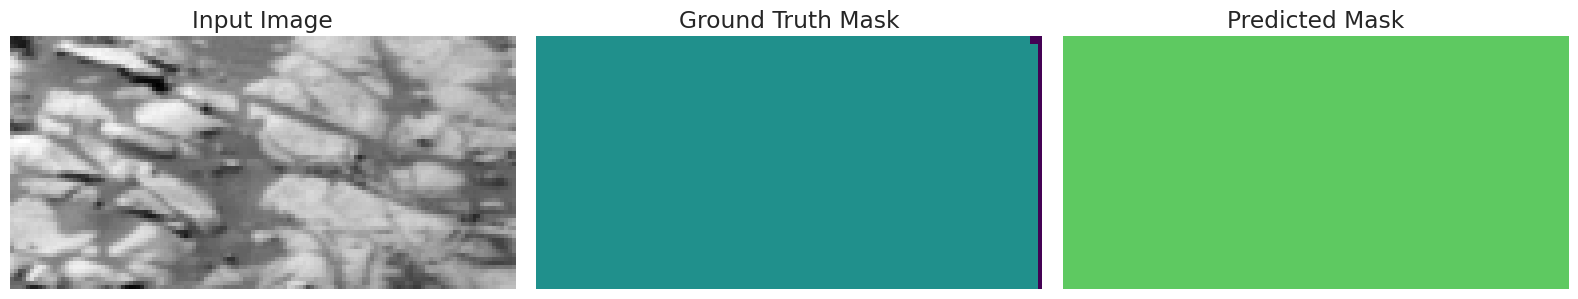

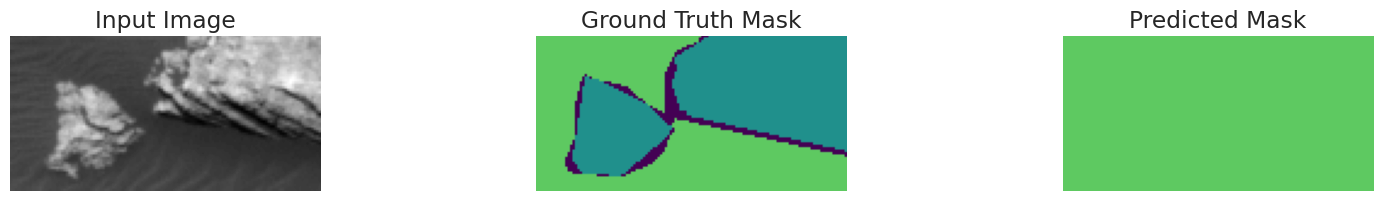

32/32 ━━━━━━━━━━━━━━━━━━━━ 436s 8s/step - accuracy: 0.3366 - loss: 0.6813 - mean_iou: 0.1875 - val_accuracy: 0.1979 - val_loss: 4.0123 - val_mean_iou: 0.0656 - learning_rate: 0.0010
SCCE weight: 0.4010 - dice weight: 0.3960 - boundary weight: 0.2030
Epoch 2/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 95s 3s/step - accuracy: 0.4175 - loss: 0.5243 - mean_iou: 0.3087 - val_accuracy: 0.1979 - val_loss: 2.4624 - val_mean_iou: 0.0656 - learning_rate: 0.0010
SCCE weight: 0.4020 - dice weight: 0.3921 - boundary weight: 0.2059
Epoch 3/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 95s 3s/step - accuracy: 0.4779 - loss: 0.4789 - mean_iou: 0.3653 - val_accuracy: 0.1979 - val_loss: 2.8000 - val_mean_iou: 0.0656 - learning_rate: 0.0010
SCCE weight: 0.4030 - dice weight: 0.3882 - boundary weight: 0.2089
Epoch 4/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 95s 3s/step - accuracy: 0.5428 - loss: 0.4256 - mean_iou: 0.4449 - val_accuracy: 0.1979 - val_loss: 3.0344 - val_mean_iou: 0.0656 - learning_rate: 0.0010
SCCE weight: 0.4039 - dice weight: 

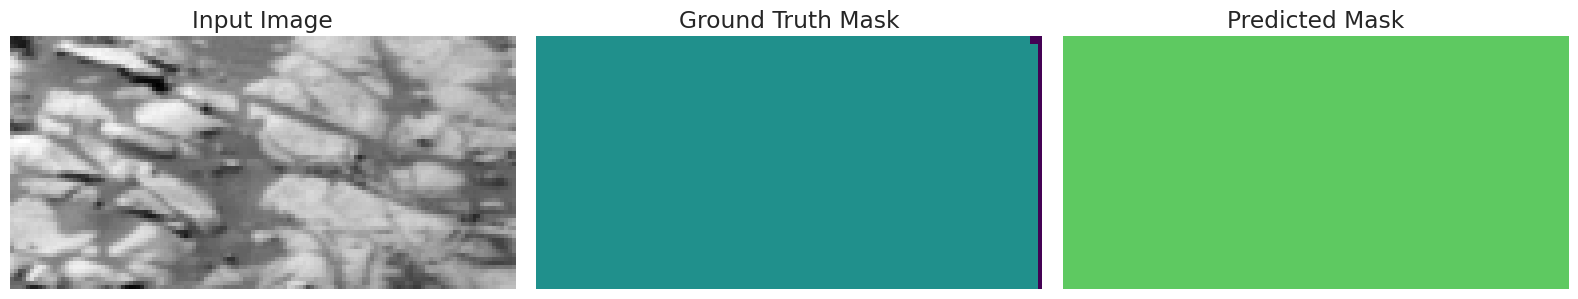

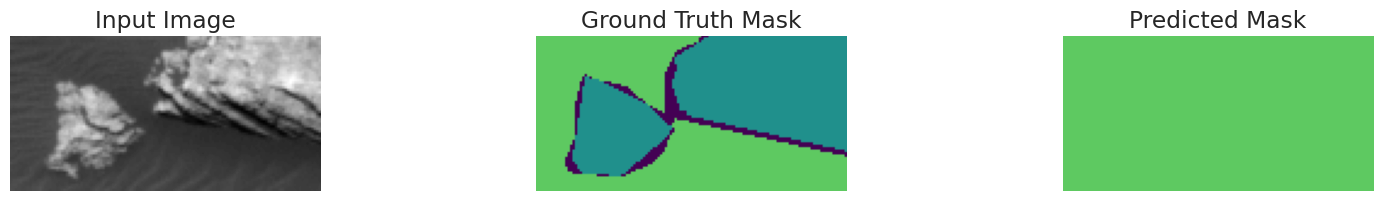

32/32 ━━━━━━━━━━━━━━━━━━━━ 96s 3s/step - accuracy: 0.5534 - loss: 0.4206 - mean_iou: 0.4579 - val_accuracy: 0.1979 - val_loss: 3.6255 - val_mean_iou: 0.0656 - learning_rate: 0.0010
SCCE weight: 0.4058 - dice weight: 0.3767 - boundary weight: 0.2175
Epoch 7/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 95s 3s/step - accuracy: 0.5916 - loss: 0.3818 - mean_iou: 0.5087 - val_accuracy: 0.1979 - val_loss: 3.2574 - val_mean_iou: 0.0656 - learning_rate: 0.0010
SCCE weight: 0.4068 - dice weight: 0.3729 - boundary weight: 0.2203
Epoch 8/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 95s 3s/step - accuracy: 0.5860 - loss: 0.3779 - mean_iou: 0.5069 - val_accuracy: 0.1979 - val_loss: 3.0401 - val_mean_iou: 0.0656 - learning_rate: 0.0010
SCCE weight: 0.4077 - dice weight: 0.3692 - boundary weight: 0.2231
Epoch 9/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 95s 3s/step - accuracy: 0.6046 - loss: 0.3699 - mean_iou: 0.5270 - val_accuracy: 0.1979 - val_loss: 3.1269 - val_mean_iou: 0.0656 - learning_rate: 0.0010
SCCE weight: 0.4086 - dice weight: 0

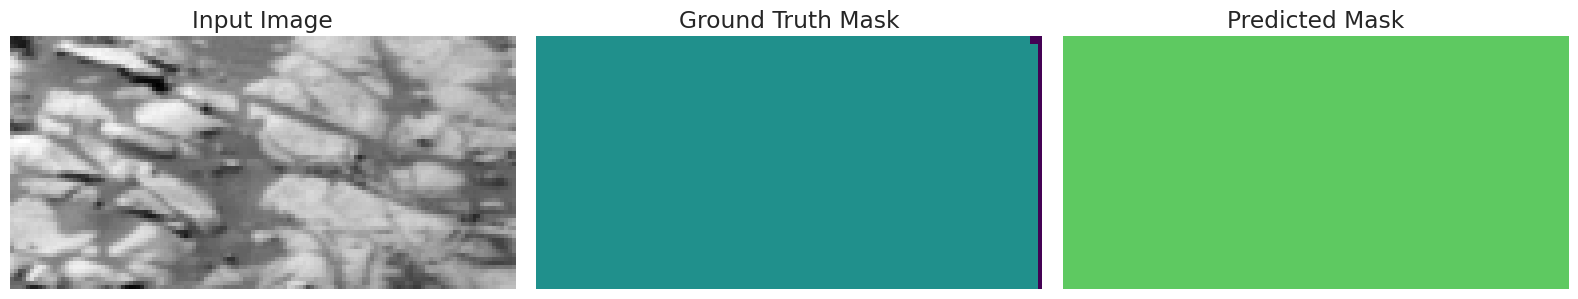

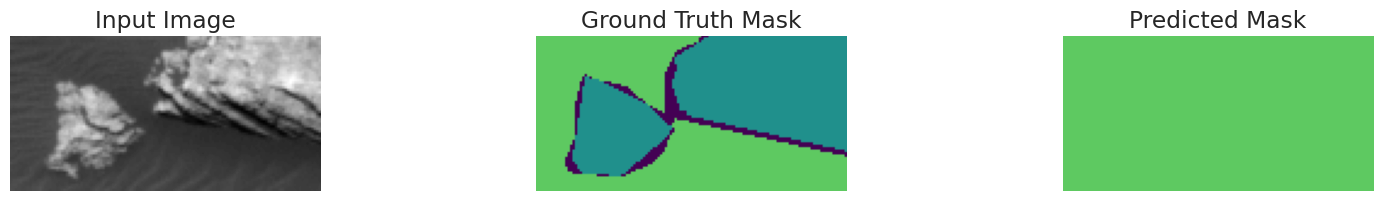

32/32 ━━━━━━━━━━━━━━━━━━━━ 96s 3s/step - accuracy: 0.6139 - loss: 0.3485 - mean_iou: 0.5440 - val_accuracy: 0.1979 - val_loss: 3.1038 - val_mean_iou: 0.0656 - learning_rate: 0.0010
SCCE weight: 0.4104 - dice weight: 0.3583 - boundary weight: 0.2313
Epoch 12/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 96s 3s/step - accuracy: 0.6284 - loss: 0.3331 - mean_iou: 0.5609 - val_accuracy: 0.1979 - val_loss: 2.4801 - val_mean_iou: 0.0656 - learning_rate: 0.0010
SCCE weight: 0.4113 - dice weight: 0.3547 - boundary weight: 0.2340
Epoch 13/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 96s 3s/step - accuracy: 0.6272 - loss: 0.3259 - mean_iou: 0.5587 - val_accuracy: 0.2057 - val_loss: 2.2861 - val_mean_iou: 0.0719 - learning_rate: 0.0010
SCCE weight: 0.4122 - dice weight: 0.3512 - boundary weight: 0.2366
Epoch 14/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 95s 3s/step - accuracy: 0.6301 - loss: 0.3269 - mean_iou: 0.5756 - val_accuracy: 0.2128 - val_loss: 2.1676 - val_mean_iou: 0.0777 - learning_rate: 0.0010
SCCE weight: 0.4131 - dice weight

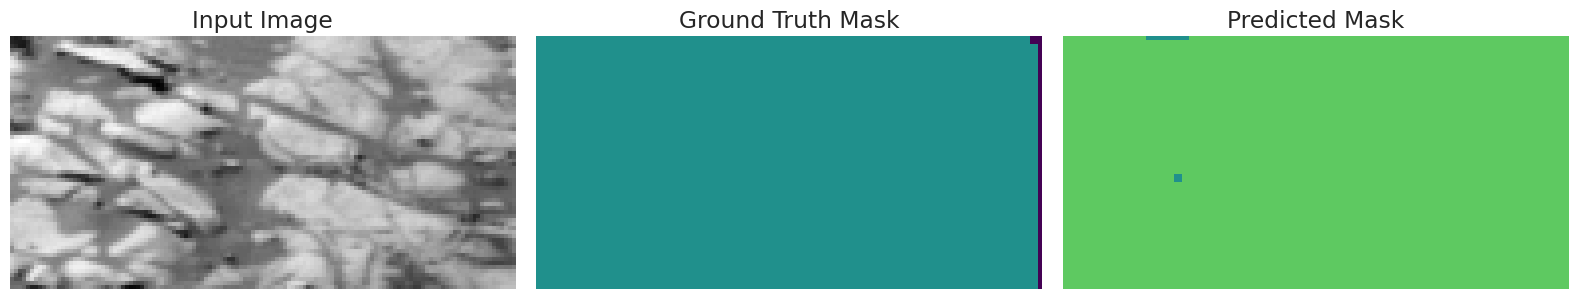

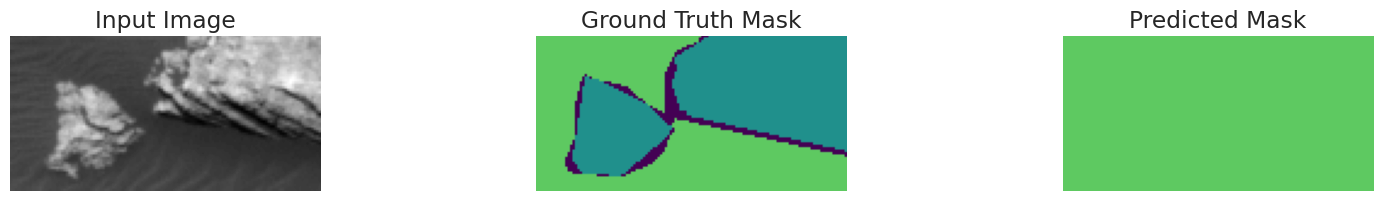

32/32 ━━━━━━━━━━━━━━━━━━━━ 96s 3s/step - accuracy: 0.6225 - loss: 0.3416 - mean_iou: 0.5557 - val_accuracy: 0.2336 - val_loss: 1.8526 - val_mean_iou: 0.1026 - learning_rate: 0.0010
SCCE weight: 0.4148 - dice weight: 0.3407 - boundary weight: 0.2444
Epoch 17/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 95s 3s/step - accuracy: 0.6252 - loss: 0.3351 - mean_iou: 0.5665 - val_accuracy: 0.2330 - val_loss: 1.8578 - val_mean_iou: 0.1019 - learning_rate: 0.0010
SCCE weight: 0.4157 - dice weight: 0.3373 - boundary weight: 0.2470
Epoch 18/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 95s 3s/step - accuracy: 0.6362 - loss: 0.3162 - mean_iou: 0.5791 - val_accuracy: 0.2874 - val_loss: 1.5090 - val_mean_iou: 0.1586 - learning_rate: 0.0010
SCCE weight: 0.4165 - dice weight: 0.3339 - boundary weight: 0.2495
Epoch 19/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 95s 3s/step - accuracy: 0.6365 - loss: 0.3169 - mean_iou: 0.5744 - val_accuracy: 0.2887 - val_loss: 1.5834 - val_mean_iou: 0.1547 - learning_rate: 0.0010
SCCE weight: 0.4174 - dice weight

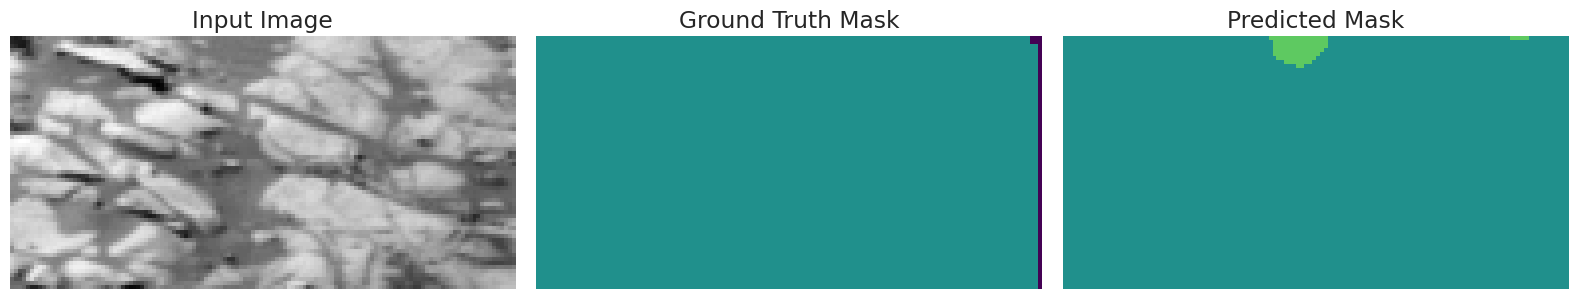

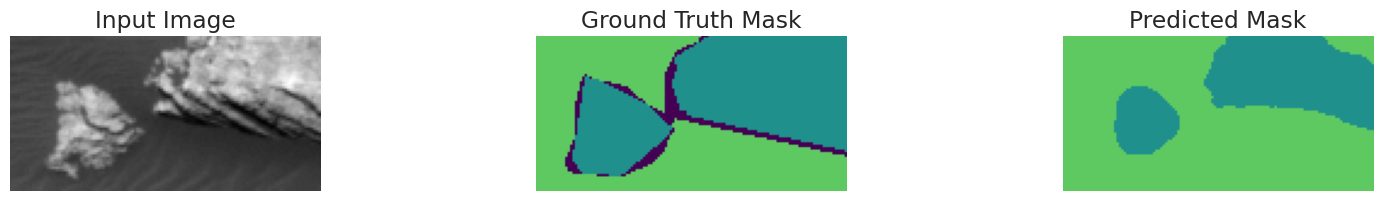

32/32 ━━━━━━━━━━━━━━━━━━━━ 97s 3s/step - accuracy: 0.6446 - loss: 0.3060 - mean_iou: 0.5919 - val_accuracy: 0.5458 - val_loss: 0.6003 - val_mean_iou: 0.4287 - learning_rate: 0.0010
SCCE weight: 0.4190 - dice weight: 0.3240 - boundary weight: 0.2570
Epoch 22/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 95s 3s/step - accuracy: 0.6477 - loss: 0.2976 - mean_iou: 0.5983 - val_accuracy: 0.5070 - val_loss: 0.7087 - val_mean_iou: 0.3799 - learning_rate: 0.0010
SCCE weight: 0.4198 - dice weight: 0.3207 - boundary weight: 0.2595
Epoch 23/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 96s 3s/step - accuracy: 0.6436 - loss: 0.3005 - mean_iou: 0.5987 - val_accuracy: 0.5172 - val_loss: 0.6183 - val_mean_iou: 0.3889 - learning_rate: 0.0010
SCCE weight: 0.4206 - dice weight: 0.3175 - boundary weight: 0.2619
Epoch 24/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 95s 3s/step - accuracy: 0.6458 - loss: 0.2963 - mean_iou: 0.6034 - val_accuracy: 0.5516 - val_loss: 0.5906 - val_mean_iou: 0.4503 - learning_rate: 0.0010
SCCE weight: 0.4214 - dice weight

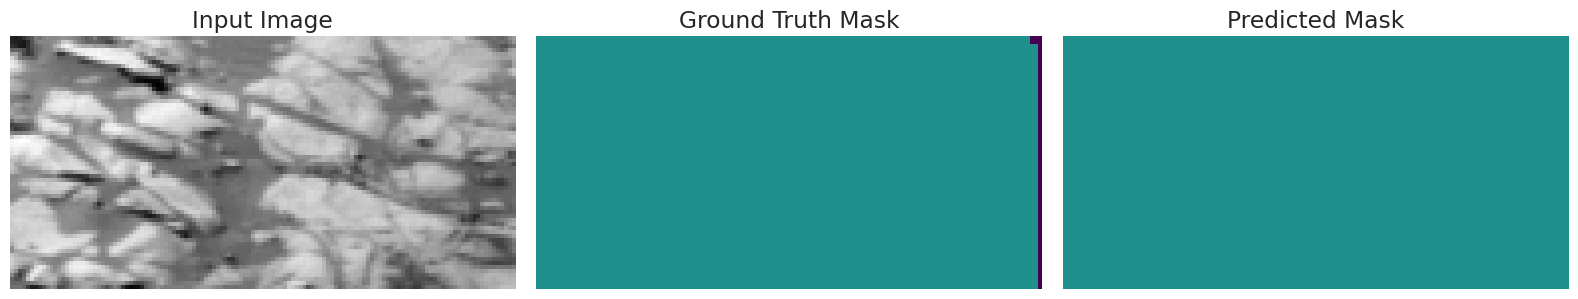

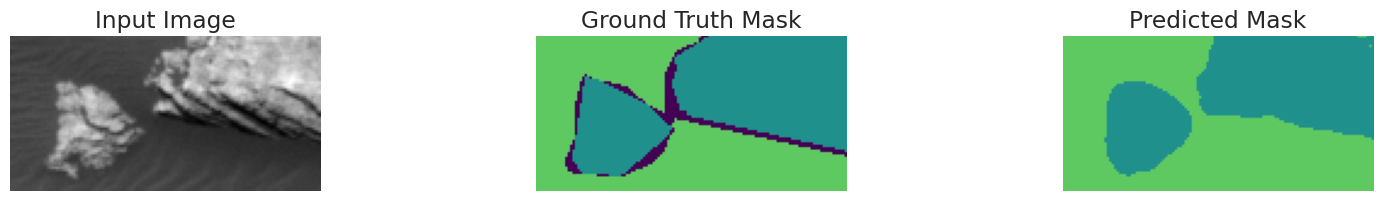

32/32 ━━━━━━━━━━━━━━━━━━━━ 96s 3s/step - accuracy: 0.6584 - loss: 0.2867 - mean_iou: 0.6154 - val_accuracy: 0.5727 - val_loss: 0.4934 - val_mean_iou: 0.4937 - learning_rate: 0.0010
SCCE weight: 0.4230 - dice weight: 0.3080 - boundary weight: 0.2690
Epoch 27/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 95s 3s/step - accuracy: 0.6506 - loss: 0.2866 - mean_iou: 0.6052 - val_accuracy: 0.5499 - val_loss: 0.6129 - val_mean_iou: 0.4332 - learning_rate: 0.0010
SCCE weight: 0.4238 - dice weight: 0.3048 - boundary weight: 0.2714
Epoch 28/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 95s 3s/step - accuracy: 0.6618 - loss: 0.2801 - mean_iou: 0.6279 - val_accuracy: 0.5719 - val_loss: 0.4760 - val_mean_iou: 0.4674 - learning_rate: 0.0010
SCCE weight: 0.4246 - dice weight: 0.3018 - boundary weight: 0.2737
Epoch 29/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 95s 3s/step - accuracy: 0.6555 - loss: 0.2774 - mean_iou: 0.6306 - val_accuracy: 0.6234 - val_loss: 0.4141 - val_mean_iou: 0.5586 - learning_rate: 0.0010
SCCE weight: 0.4253 - dice weight

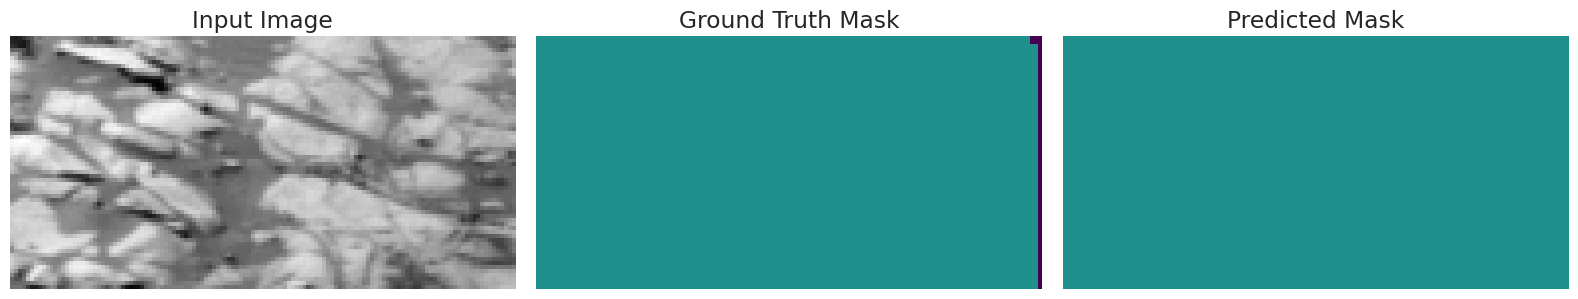

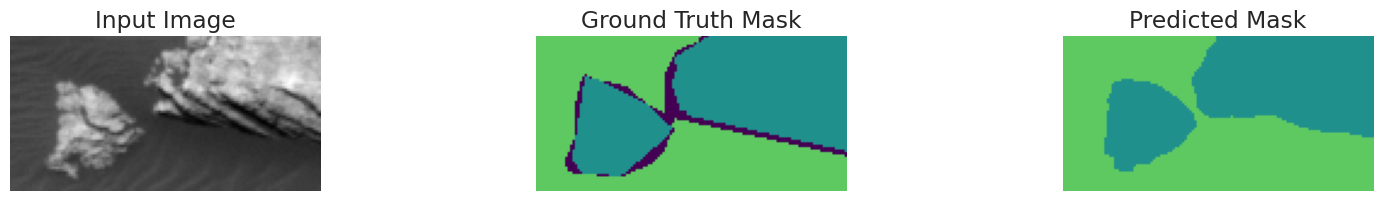

32/32 ━━━━━━━━━━━━━━━━━━━━ 96s 3s/step - accuracy: 0.6557 - loss: 0.2737 - mean_iou: 0.6247 - val_accuracy: 0.4836 - val_loss: 0.5523 - val_mean_iou: 0.3877 - learning_rate: 0.0010
SCCE weight: 0.4268 - dice weight: 0.2926 - boundary weight: 0.2805
Epoch 32/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 95s 3s/step - accuracy: 0.6629 - loss: 0.2779 - mean_iou: 0.6193 - val_accuracy: 0.6214 - val_loss: 0.4813 - val_mean_iou: 0.5324 - learning_rate: 0.0010
SCCE weight: 0.4276 - dice weight: 0.2897 - boundary weight: 0.2828
Epoch 33/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 95s 3s/step - accuracy: 0.6557 - loss: 0.2840 - mean_iou: 0.6115 - val_accuracy: 0.5144 - val_loss: 0.6963 - val_mean_iou: 0.2834 - learning_rate: 0.0010
SCCE weight: 0.4283 - dice weight: 0.2867 - boundary weight: 0.2850
Epoch 34/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 95s 3s/step - accuracy: 0.6429 - loss: 0.2891 - mean_iou: 0.6024 - val_accuracy: 0.2870 - val_loss: 5.5278 - val_mean_iou: 0.1199 - learning_rate: 0.0010
SCCE weight: 0.4291 - dice weight

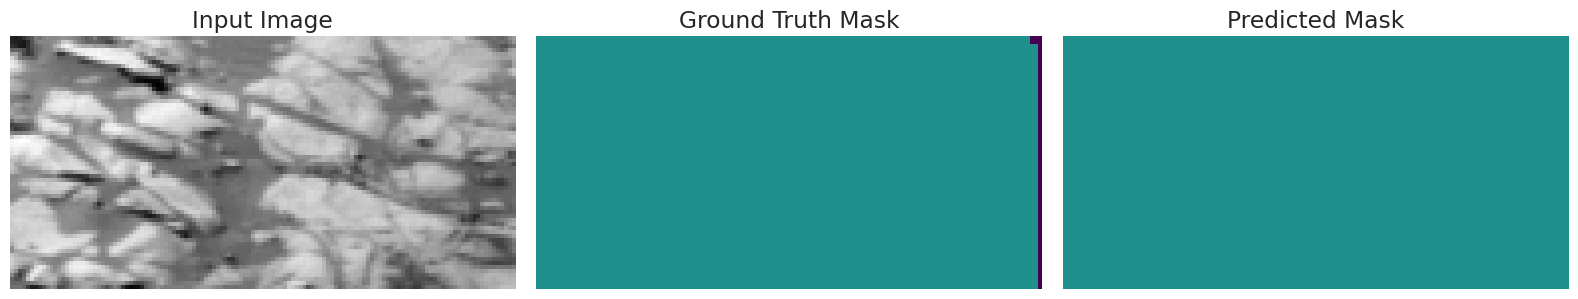

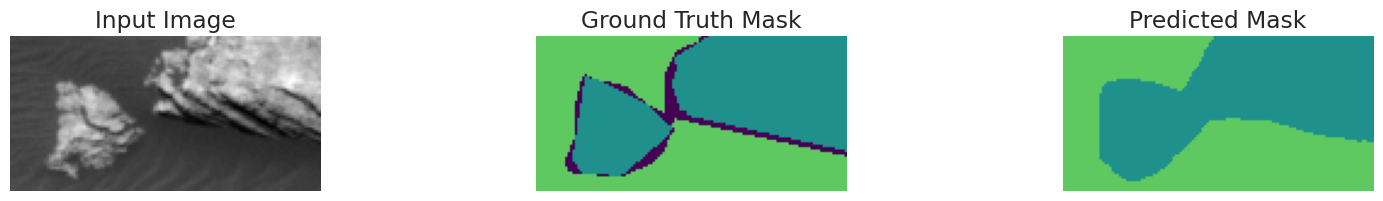

32/32 ━━━━━━━━━━━━━━━━━━━━ 96s 3s/step - accuracy: 0.6633 - loss: 0.2709 - mean_iou: 0.6350 - val_accuracy: 0.6503 - val_loss: 0.3886 - val_mean_iou: 0.5979 - learning_rate: 0.0010
SCCE weight: 0.4305 - dice weight: 0.2780 - boundary weight: 0.2915
Epoch 37/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 95s 3s/step - accuracy: 0.6688 - loss: 0.2548 - mean_iou: 0.6617 - val_accuracy: 0.6295 - val_loss: 0.4790 - val_mean_iou: 0.5531 - learning_rate: 0.0010
SCCE weight: 0.4312 - dice weight: 0.2751 - boundary weight: 0.2937
Epoch 38/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 95s 3s/step - accuracy: 0.6703 - loss: 0.2551 - mean_iou: 0.6626 - val_accuracy: 0.5981 - val_loss: 0.4543 - val_mean_iou: 0.5046 - learning_rate: 0.0010
SCCE weight: 0.4319 - dice weight: 0.2723 - boundary weight: 0.2958
Epoch 39/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 95s 3s/step - accuracy: 0.6672 - loss: 0.2645 - mean_iou: 0.6473 - val_accuracy: 0.6125 - val_loss: 0.5070 - val_mean_iou: 0.5272 - learning_rate: 0.0010
SCCE weight: 0.4326 - dice weight

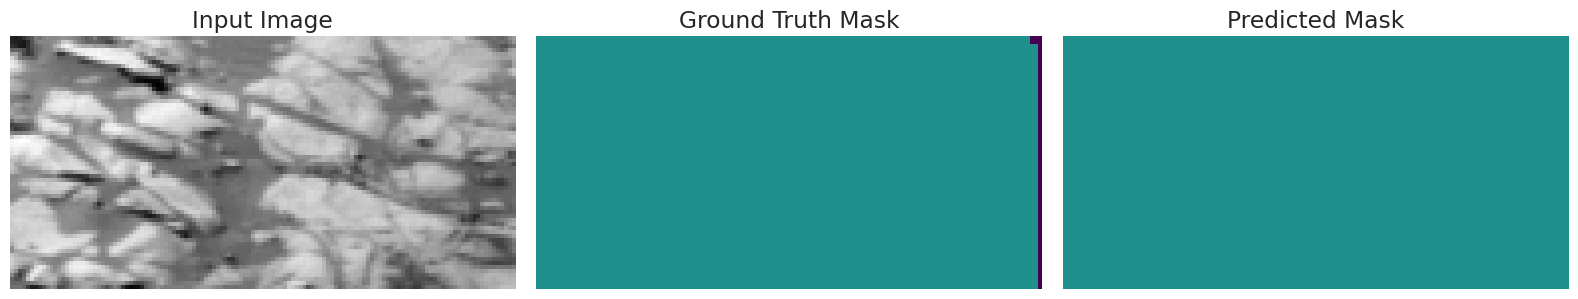

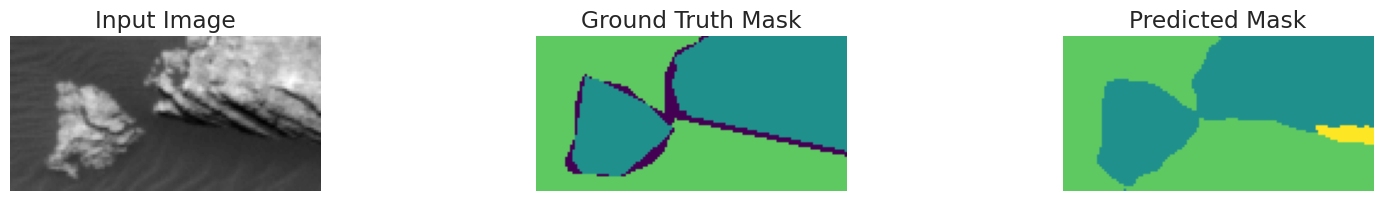

32/32 ━━━━━━━━━━━━━━━━━━━━ 96s 3s/step - accuracy: 0.6678 - loss: 0.2628 - mean_iou: 0.6536 - val_accuracy: 0.4834 - val_loss: 0.5428 - val_mean_iou: 0.3939 - learning_rate: 0.0010
SCCE weight: 0.4340 - dice weight: 0.2639 - boundary weight: 0.3021
Epoch 42/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 95s 3s/step - accuracy: 0.6518 - loss: 0.2755 - mean_iou: 0.6150 - val_accuracy: 0.5947 - val_loss: 0.4237 - val_mean_iou: 0.5131 - learning_rate: 0.0010
SCCE weight: 0.4347 - dice weight: 0.2612 - boundary weight: 0.3041
Epoch 43/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 96s 3s/step - accuracy: 0.6716 - loss: 0.2654 - mean_iou: 0.6445 - val_accuracy: 0.6240 - val_loss: 0.3719 - val_mean_iou: 0.5538 - learning_rate: 0.0010
SCCE weight: 0.4354 - dice weight: 0.2584 - boundary weight: 0.3062
Epoch 44/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 95s 3s/step - accuracy: 0.6565 - loss: 0.2713 - mean_iou: 0.6277 - val_accuracy: 0.5498 - val_loss: 0.4692 - val_mean_iou: 0.3640 - learning_rate: 0.0010
SCCE weight: 0.4361 - dice weight

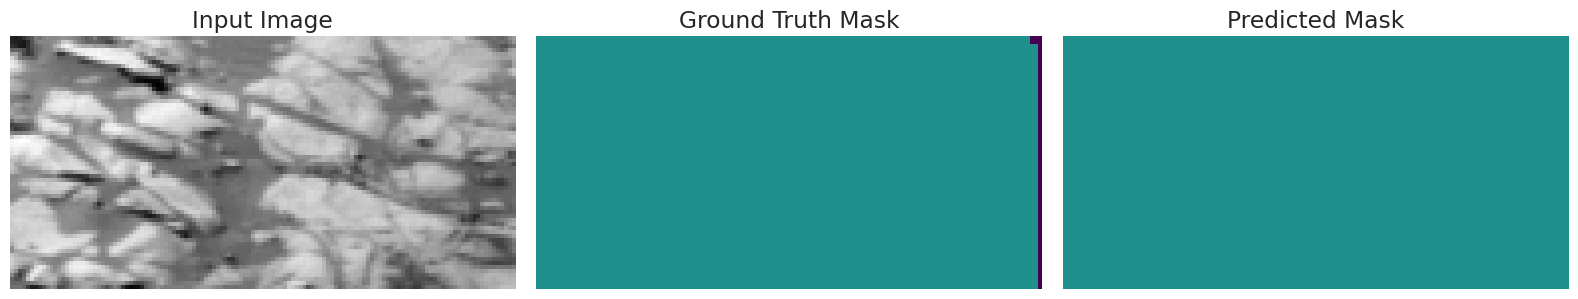

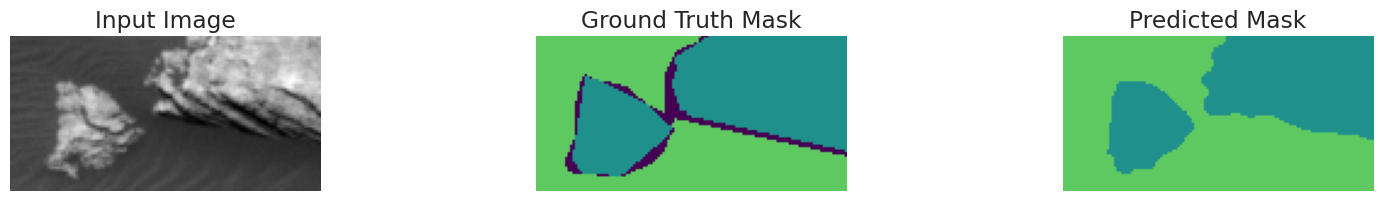

32/32 ━━━━━━━━━━━━━━━━━━━━ 96s 3s/step - accuracy: 0.6698 - loss: 0.2387 - mean_iou: 0.6755 - val_accuracy: 0.5631 - val_loss: 0.4653 - val_mean_iou: 0.4966 - learning_rate: 0.0010
SCCE weight: 0.4374 - dice weight: 0.2504 - boundary weight: 0.3122
Epoch 47/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 95s 3s/step - accuracy: 0.6721 - loss: 0.2406 - mean_iou: 0.6658 - val_accuracy: 0.5944 - val_loss: 0.4799 - val_mean_iou: 0.5306 - learning_rate: 0.0010
SCCE weight: 0.4381 - dice weight: 0.2478 - boundary weight: 0.3142
Epoch 48/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 95s 3s/step - accuracy: 0.6704 - loss: 0.2479 - mean_iou: 0.6666 - val_accuracy: 0.6190 - val_loss: 0.4094 - val_mean_iou: 0.5474 - learning_rate: 0.0010
SCCE weight: 0.4387 - dice weight: 0.2452 - boundary weight: 0.3161
Epoch 49/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 95s 3s/step - accuracy: 0.6787 - loss: 0.2341 - mean_iou: 0.6856 - val_accuracy: 0.5921 - val_loss: 0.4256 - val_mean_iou: 0.5492 - learning_rate: 0.0010
SCCE weight: 0.4394 - dice weight

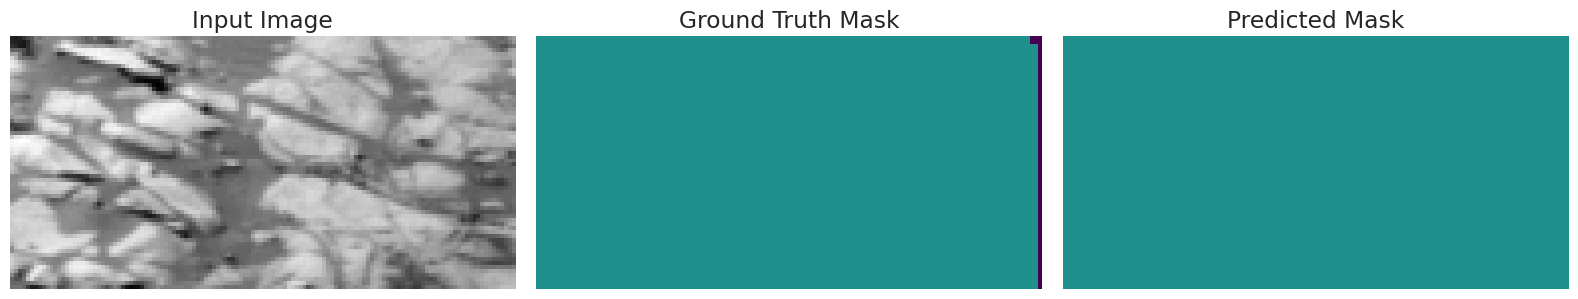

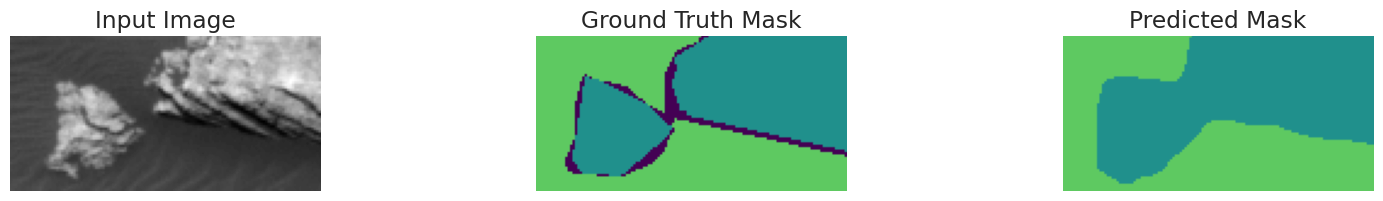

32/32 ━━━━━━━━━━━━━━━━━━━━ 96s 3s/step - accuracy: 0.6823 - loss: 0.2159 - mean_iou: 0.7172 - val_accuracy: 0.6594 - val_loss: 0.4044 - val_mean_iou: 0.5903 - learning_rate: 0.0010
SCCE weight: 0.4406 - dice weight: 0.2375 - boundary weight: 0.3219
Epoch 52/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 95s 3s/step - accuracy: 0.6800 - loss: 0.2172 - mean_iou: 0.6956 - val_accuracy: 0.6438 - val_loss: 0.3657 - val_mean_iou: 0.5884 - learning_rate: 0.0010
SCCE weight: 0.4413 - dice weight: 0.2349 - boundary weight: 0.3238
Epoch 53/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 95s 3s/step - accuracy: 0.6852 - loss: 0.2238 - mean_iou: 0.7175 - val_accuracy: 0.6529 - val_loss: 0.3819 - val_mean_iou: 0.6020 - learning_rate: 0.0010
SCCE weight: 0.4419 - dice weight: 0.2324 - boundary weight: 0.3257
Epoch 54/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 95s 3s/step - accuracy: 0.6837 - loss: 0.2244 - mean_iou: 0.7121 - val_accuracy: 0.6234 - val_loss: 0.4447 - val_mean_iou: 0.5471 - learning_rate: 0.0010
SCCE weight: 0.4425 - dice weight

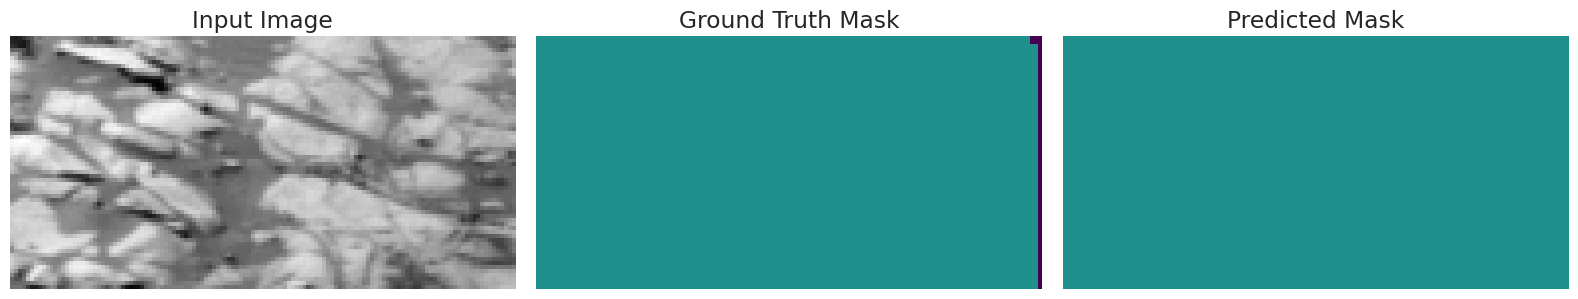

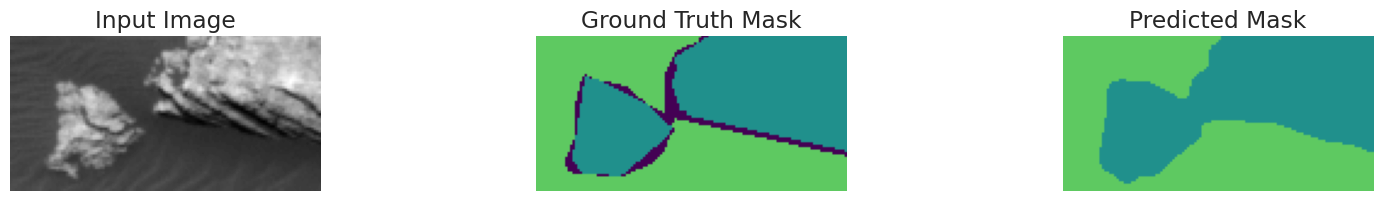

32/32 ━━━━━━━━━━━━━━━━━━━━ 96s 3s/step - accuracy: 0.6820 - loss: 0.2181 - mean_iou: 0.7430 - val_accuracy: 0.5797 - val_loss: 0.4717 - val_mean_iou: 0.5048 - learning_rate: 0.0010
SCCE weight: 0.4437 - dice weight: 0.2250 - boundary weight: 0.3312
Epoch 57/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 95s 3s/step - accuracy: 0.6849 - loss: 0.2048 - mean_iou: 0.7628 - val_accuracy: 0.5951 - val_loss: 0.6724 - val_mean_iou: 0.4981 - learning_rate: 0.0010
SCCE weight: 0.4444 - dice weight: 0.2226 - boundary weight: 0.3331
Epoch 58/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 95s 3s/step - accuracy: 0.6851 - loss: 0.2174 - mean_iou: 0.7150 - val_accuracy: 0.6146 - val_loss: 0.4564 - val_mean_iou: 0.5355 - learning_rate: 0.0010
SCCE weight: 0.4450 - dice weight: 0.2202 - boundary weight: 0.3349
Epoch 59/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 95s 3s/step - accuracy: 0.6816 - loss: 0.2241 - mean_iou: 0.6939 - val_accuracy: 0.5985 - val_loss: 0.4241 - val_mean_iou: 0.4949 - learning_rate: 0.0010
SCCE weight: 0.4456 - dice weight

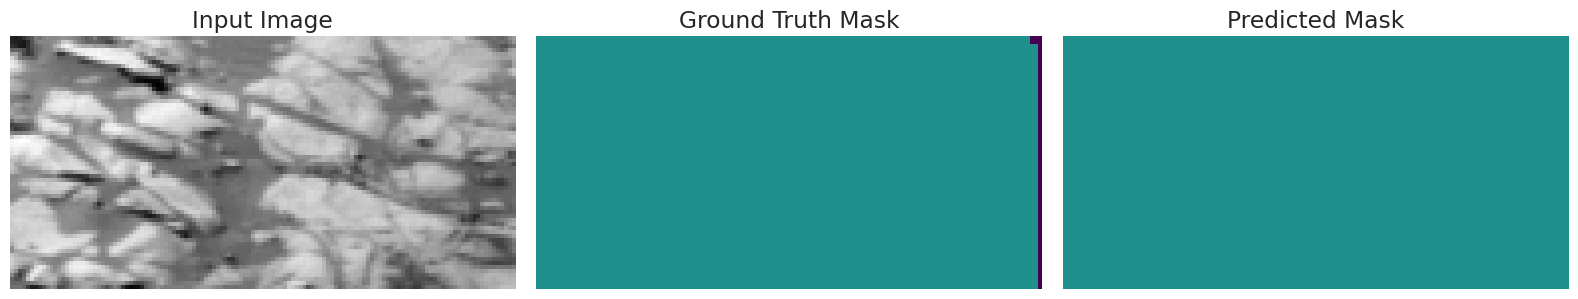

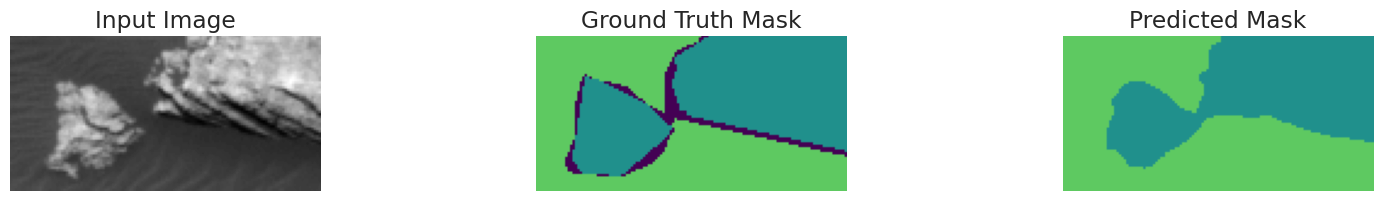

32/32 ━━━━━━━━━━━━━━━━━━━━ 96s 3s/step - accuracy: 0.6756 - loss: 0.2117 - mean_iou: 0.6994 - val_accuracy: 0.5724 - val_loss: 0.5660 - val_mean_iou: 0.4724 - learning_rate: 0.0010
SCCE weight: 0.4467 - dice weight: 0.2130 - boundary weight: 0.3402
Epoch 62/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 95s 3s/step - accuracy: 0.6760 - loss: 0.2379 - mean_iou: 0.6826 - val_accuracy: 0.6587 - val_loss: 0.4126 - val_mean_iou: 0.5889 - learning_rate: 0.0010
SCCE weight: 0.4473 - dice weight: 0.2107 - boundary weight: 0.3420
Epoch 63/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 95s 3s/step - accuracy: 0.6789 - loss: 0.2242 - mean_iou: 0.6883 - val_accuracy: 0.5662 - val_loss: 0.4944 - val_mean_iou: 0.4764 - learning_rate: 0.0010
SCCE weight: 0.4479 - dice weight: 0.2084 - boundary weight: 0.3437
Epoch 64/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 95s 3s/step - accuracy: 0.6744 - loss: 0.2263 - mean_iou: 0.6793 - val_accuracy: 0.6485 - val_loss: 0.4371 - val_mean_iou: 0.5607 - learning_rate: 0.0010
SCCE weight: 0.4485 - dice weight

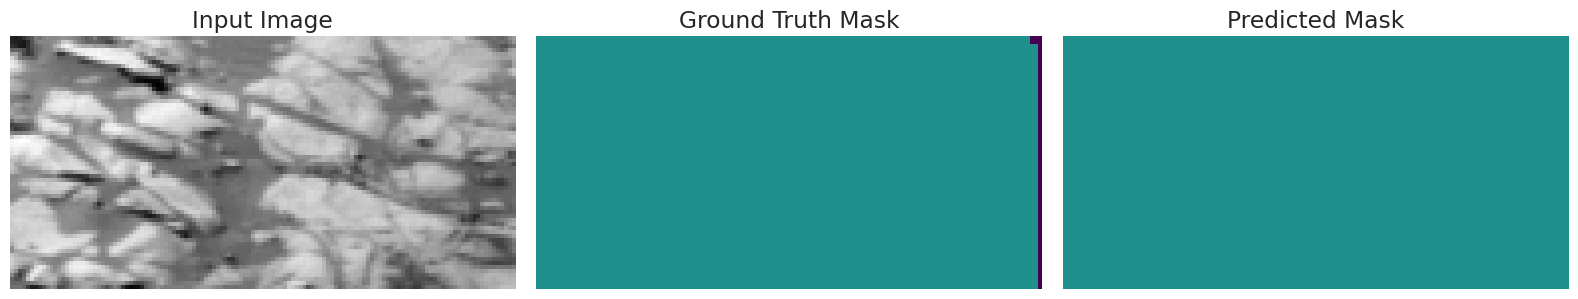

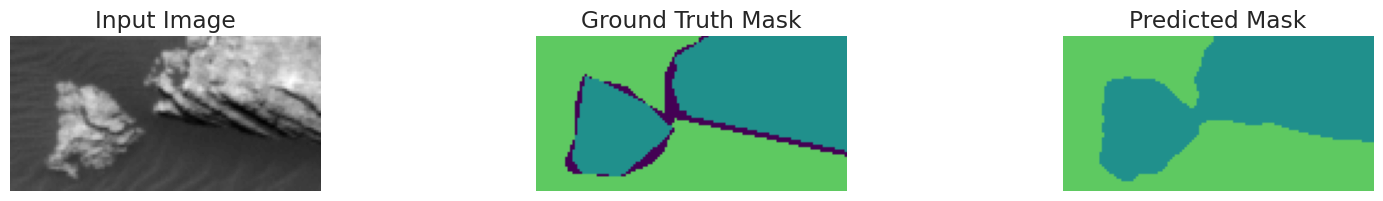

32/32 ━━━━━━━━━━━━━━━━━━━━ 96s 3s/step - accuracy: 0.6947 - loss: 0.1947 - mean_iou: 0.7638 - val_accuracy: 0.6422 - val_loss: 0.4316 - val_mean_iou: 0.5660 - learning_rate: 0.0010
SCCE weight: 0.4496 - dice weight: 0.2015 - boundary weight: 0.3489
Epoch 67/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 95s 3s/step - accuracy: 0.6827 - loss: 0.2056 - mean_iou: 0.7228 - val_accuracy: 0.6255 - val_loss: 0.4291 - val_mean_iou: 0.5590 - learning_rate: 0.0010
SCCE weight: 0.4502 - dice weight: 0.1993 - boundary weight: 0.3506
Epoch 68/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 95s 3s/step - accuracy: 0.6998 - loss: 0.1865 - mean_iou: 0.7913 - val_accuracy: 0.6654 - val_loss: 0.3653 - val_mean_iou: 0.6130 - learning_rate: 1.0000e-04
SCCE weight: 0.4507 - dice weight: 0.1970 - boundary weight: 0.3522
Epoch 69/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 95s 3s/step - accuracy: 0.7032 - loss: 0.1691 - mean_iou: 0.8033 - val_accuracy: 0.6672 - val_loss: 0.3593 - val_mean_iou: 0.6114 - learning_rate: 1.0000e-04
SCCE weight: 0.4513 - dic

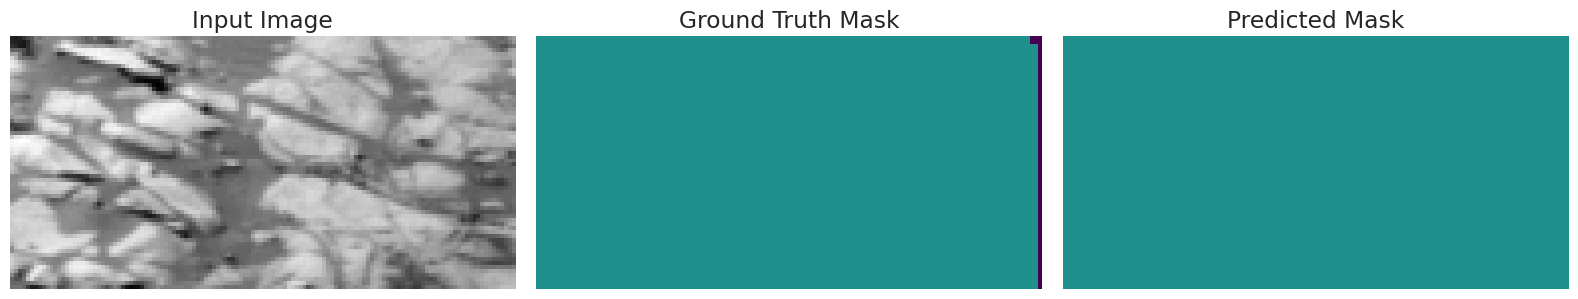

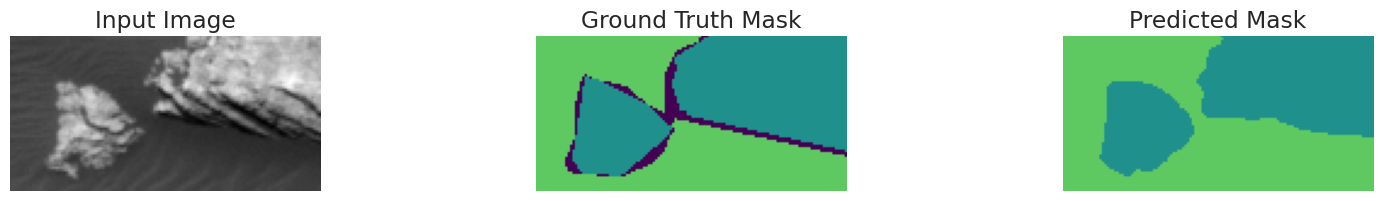

32/32 ━━━━━━━━━━━━━━━━━━━━ 96s 3s/step - accuracy: 0.7025 - loss: 0.1673 - mean_iou: 0.8268 - val_accuracy: 0.6784 - val_loss: 0.3360 - val_mean_iou: 0.6323 - learning_rate: 1.0000e-04
SCCE weight: 0.4524 - dice weight: 0.1904 - boundary weight: 0.3572
Epoch 72/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 95s 3s/step - accuracy: 0.7071 - loss: 0.1707 - mean_iou: 0.8280 - val_accuracy: 0.6817 - val_loss: 0.3364 - val_mean_iou: 0.6384 - learning_rate: 1.0000e-04
SCCE weight: 0.4529 - dice weight: 0.1882 - boundary weight: 0.3588
Epoch 73/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 95s 3s/step - accuracy: 0.7048 - loss: 0.1669 - mean_iou: 0.8205 - val_accuracy: 0.6832 - val_loss: 0.3355 - val_mean_iou: 0.6392 - learning_rate: 1.0000e-04
SCCE weight: 0.4535 - dice weight: 0.1861 - boundary weight: 0.3604
Epoch 74/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 95s 3s/step - accuracy: 0.7075 - loss: 0.1636 - mean_iou: 0.8244 - val_accuracy: 0.6837 - val_loss: 0.3257 - val_mean_iou: 0.6423 - learning_rate: 1.0000e-04
SCCE weight: 0.45

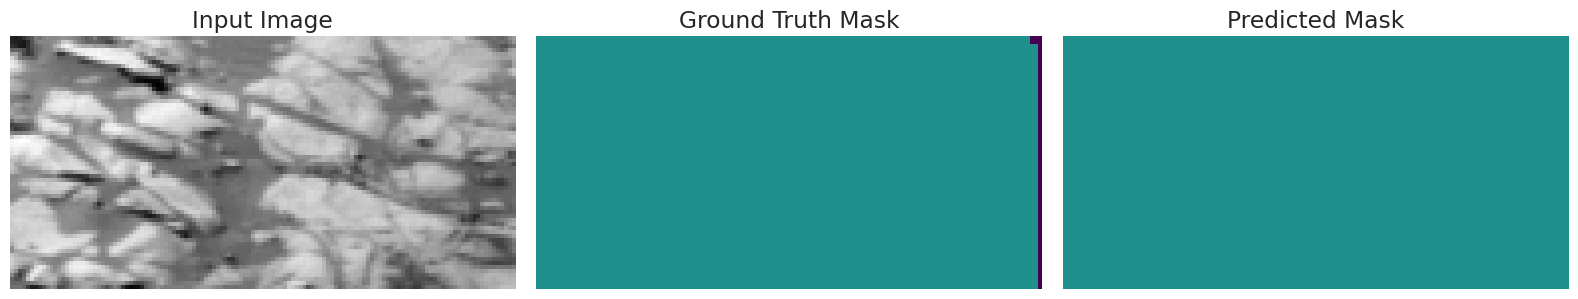

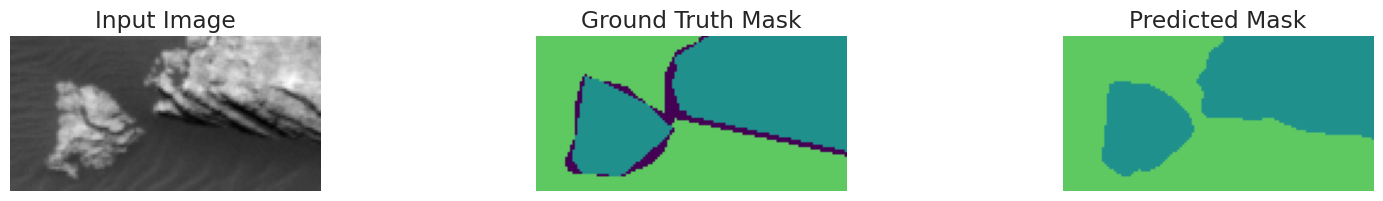

32/32 ━━━━━━━━━━━━━━━━━━━━ 96s 3s/step - accuracy: 0.7046 - loss: 0.1627 - mean_iou: 0.8196 - val_accuracy: 0.6827 - val_loss: 0.3358 - val_mean_iou: 0.6332 - learning_rate: 1.0000e-04
SCCE weight: 0.4551 - dice weight: 0.1797 - boundary weight: 0.3652
Epoch 77/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 95s 3s/step - accuracy: 0.7039 - loss: 0.1503 - mean_iou: 0.8508 - val_accuracy: 0.6860 - val_loss: 0.3402 - val_mean_iou: 0.6380 - learning_rate: 1.0000e-04
SCCE weight: 0.4556 - dice weight: 0.1776 - boundary weight: 0.3668
Epoch 78/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 95s 3s/step - accuracy: 0.7110 - loss: 0.1697 - mean_iou: 0.8236 - val_accuracy: 0.6851 - val_loss: 0.3452 - val_mean_iou: 0.6369 - learning_rate: 1.0000e-04
SCCE weight: 0.4561 - dice weight: 0.1755 - boundary weight: 0.3683
Epoch 79/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 95s 3s/step - accuracy: 0.7091 - loss: 0.1627 - mean_iou: 0.8253 - val_accuracy: 0.6860 - val_loss: 0.3405 - val_mean_iou: 0.6384 - learning_rate: 1.0000e-04
SCCE weight: 0.45

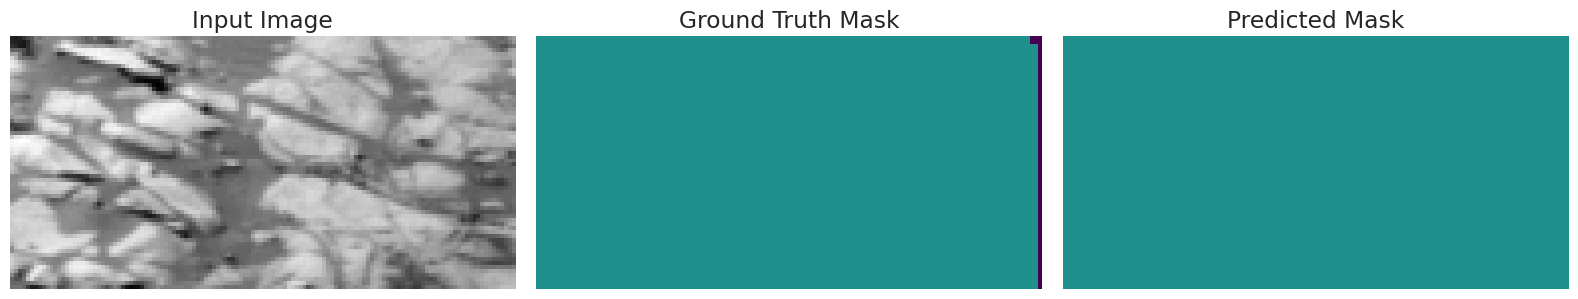

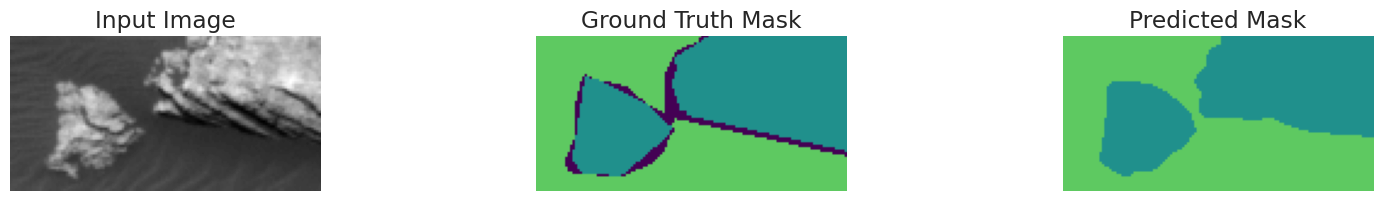

32/32 ━━━━━━━━━━━━━━━━━━━━ 97s 3s/step - accuracy: 0.7103 - loss: 0.1516 - mean_iou: 0.8365 - val_accuracy: 0.6843 - val_loss: 0.3398 - val_mean_iou: 0.6364 - learning_rate: 1.0000e-04
SCCE weight: 0.4577 - dice weight: 0.1694 - boundary weight: 0.3730
Epoch 82/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 95s 3s/step - accuracy: 0.7114 - loss: 0.1556 - mean_iou: 0.8517 - val_accuracy: 0.6878 - val_loss: 0.3433 - val_mean_iou: 0.6421 - learning_rate: 1.0000e-04
SCCE weight: 0.4582 - dice weight: 0.1674 - boundary weight: 0.3745
Epoch 83/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 95s 3s/step - accuracy: 0.7091 - loss: 0.1575 - mean_iou: 0.8445 - val_accuracy: 0.6873 - val_loss: 0.3453 - val_mean_iou: 0.6417 - learning_rate: 1.0000e-04
SCCE weight: 0.4587 - dice weight: 0.1654 - boundary weight: 0.3760
Epoch 84/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 95s 3s/step - accuracy: 0.7119 - loss: 0.1595 - mean_iou: 0.8589 - val_accuracy: 0.6857 - val_loss: 0.3482 - val_mean_iou: 0.6389 - learning_rate: 1.0000e-04
SCCE weight: 0.45

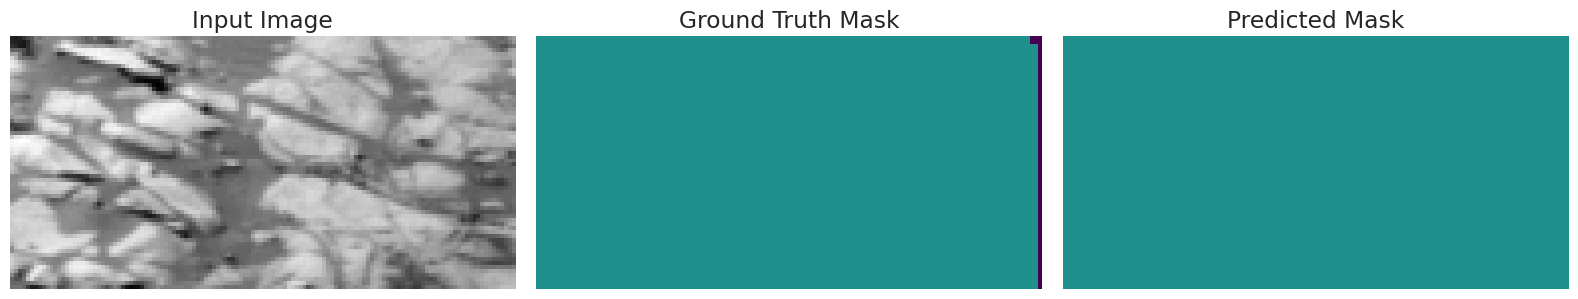

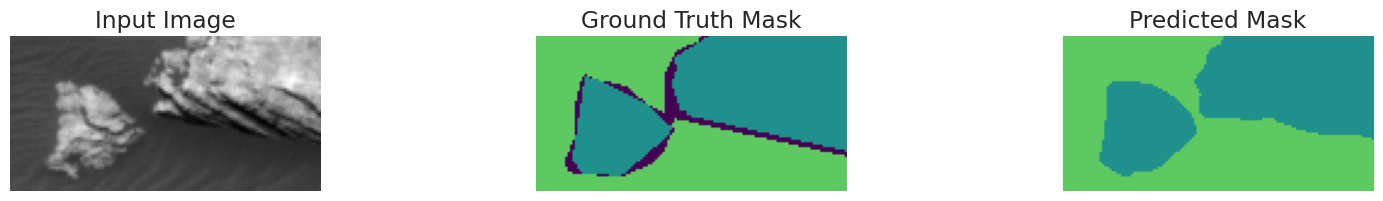

32/32 ━━━━━━━━━━━━━━━━━━━━ 96s 3s/step - accuracy: 0.7105 - loss: 0.1551 - mean_iou: 0.8520 - val_accuracy: 0.6865 - val_loss: 0.3501 - val_mean_iou: 0.6398 - learning_rate: 1.0000e-04
SCCE weight: 0.4601 - dice weight: 0.1594 - boundary weight: 0.3804
Epoch 87/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 95s 3s/step - accuracy: 0.7120 - loss: 0.1557 - mean_iou: 0.8567 - val_accuracy: 0.6844 - val_loss: 0.3533 - val_mean_iou: 0.6343 - learning_rate: 1.0000e-04
SCCE weight: 0.4606 - dice weight: 0.1575 - boundary weight: 0.3819
Epoch 88/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 96s 3s/step - accuracy: 0.7124 - loss: 0.1470 - mean_iou: 0.8677 - val_accuracy: 0.6870 - val_loss: 0.3510 - val_mean_iou: 0.6393 - learning_rate: 1.0000e-04
SCCE weight: 0.4611 - dice weight: 0.1556 - boundary weight: 0.3833
Epoch 89/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 96s 3s/step - accuracy: 0.7053 - loss: 0.1573 - mean_iou: 0.8547 - val_accuracy: 0.6879 - val_loss: 0.3659 - val_mean_iou: 0.6409 - learning_rate: 1.0000e-04
SCCE weight: 0.46

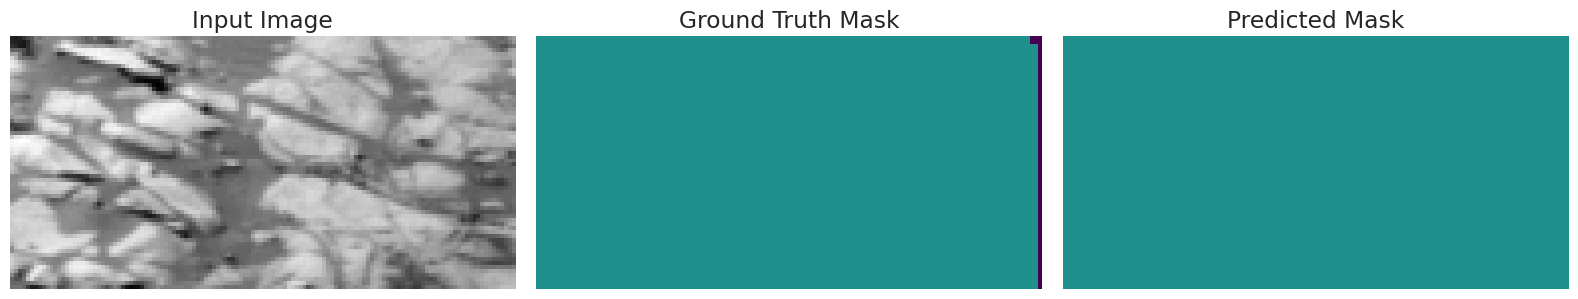

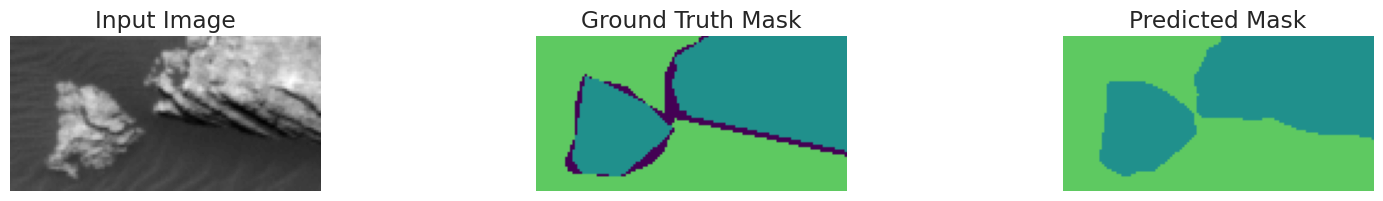

32/32 ━━━━━━━━━━━━━━━━━━━━ 97s 3s/step - accuracy: 0.7118 - loss: 0.1509 - mean_iou: 0.8449 - val_accuracy: 0.6870 - val_loss: 0.3591 - val_mean_iou: 0.6392 - learning_rate: 1.0000e-05
SCCE weight: 0.4625 - dice weight: 0.1498 - boundary weight: 0.3876
Epoch 92/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 96s 3s/step - accuracy: 0.7090 - loss: 0.1490 - mean_iou: 0.8467 - val_accuracy: 0.6864 - val_loss: 0.3561 - val_mean_iou: 0.6381 - learning_rate: 1.0000e-05
SCCE weight: 0.4630 - dice weight: 0.1479 - boundary weight: 0.3890
Epoch 93/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 95s 3s/step - accuracy: 0.7085 - loss: 0.1541 - mean_iou: 0.8519 - val_accuracy: 0.6871 - val_loss: 0.3549 - val_mean_iou: 0.6394 - learning_rate: 1.0000e-05
SCCE weight: 0.4635 - dice weight: 0.1461 - boundary weight: 0.3904
Epoch 94/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 95s 3s/step - accuracy: 0.7111 - loss: 0.1430 - mean_iou: 0.8746 - val_accuracy: 0.6870 - val_loss: 0.3544 - val_mean_iou: 0.6391 - learning_rate: 1.0000e-05
SCCE weight: 0.46

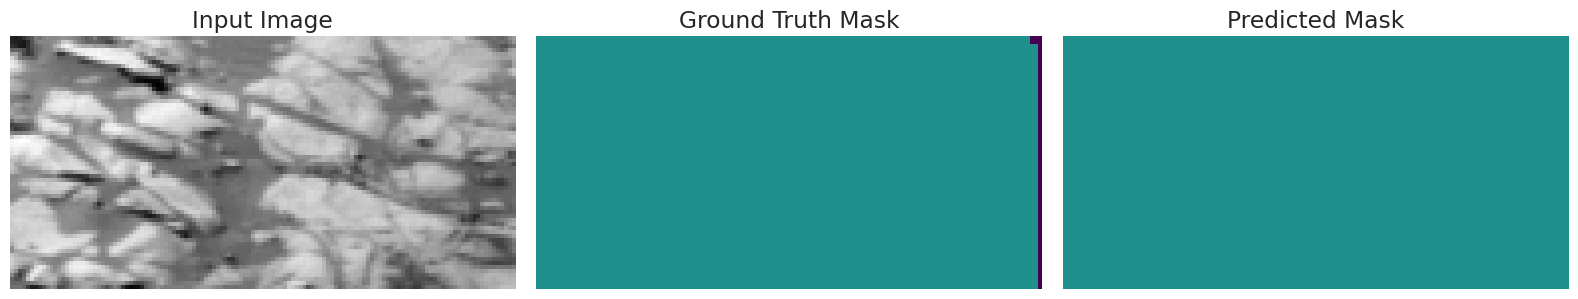

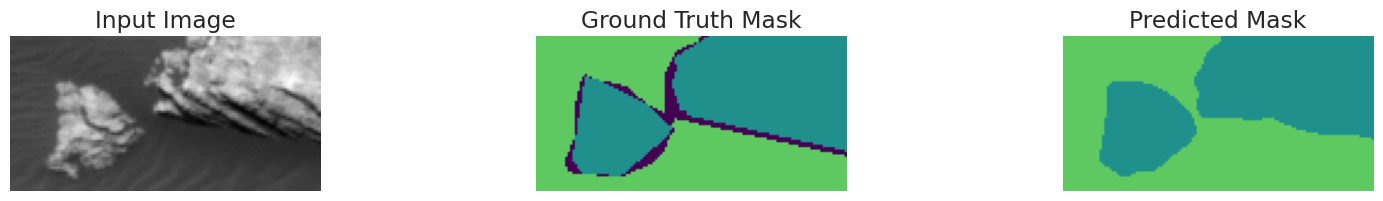

32/32 ━━━━━━━━━━━━━━━━━━━━ 97s 3s/step - accuracy: 0.7138 - loss: 0.1470 - mean_iou: 0.8457 - val_accuracy: 0.6869 - val_loss: 0.3568 - val_mean_iou: 0.6388 - learning_rate: 1.0000e-05
SCCE weight: 0.4649 - dice weight: 0.1405 - boundary weight: 0.3946
Epoch 97/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 95s 3s/step - accuracy: 0.7152 - loss: 0.1526 - mean_iou: 0.8646 - val_accuracy: 0.6871 - val_loss: 0.3577 - val_mean_iou: 0.6392 - learning_rate: 1.0000e-05
SCCE weight: 0.4653 - dice weight: 0.1387 - boundary weight: 0.3960
Epoch 98/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 95s 3s/step - accuracy: 0.7166 - loss: 0.1468 - mean_iou: 0.8876 - val_accuracy: 0.6869 - val_loss: 0.3568 - val_mean_iou: 0.6390 - learning_rate: 1.0000e-05
SCCE weight: 0.4658 - dice weight: 0.1369 - boundary weight: 0.3973
Epoch 99/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 96s 3s/step - accuracy: 0.7176 - loss: 0.1518 - mean_iou: 0.8610 - val_accuracy: 0.6872 - val_loss: 0.3559 - val_mean_iou: 0.6396 - learning_rate: 1.0000e-05
SCCE weight: 0.46

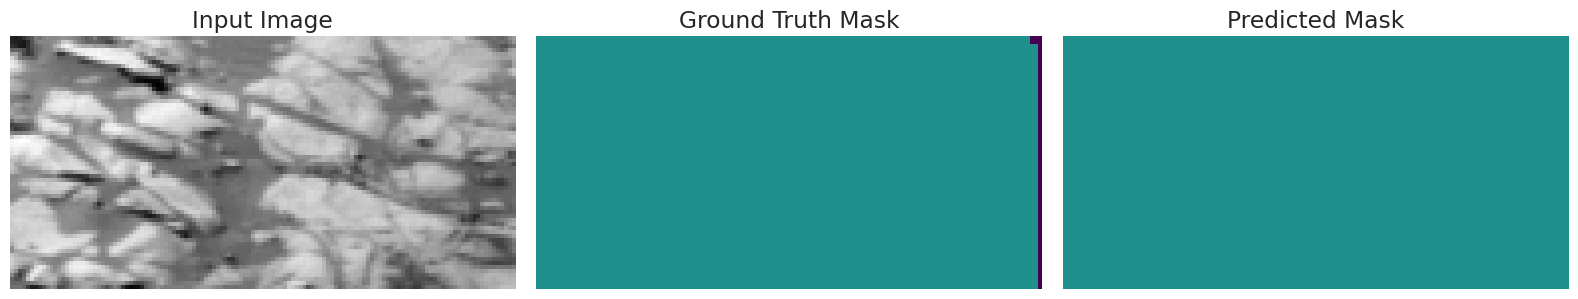

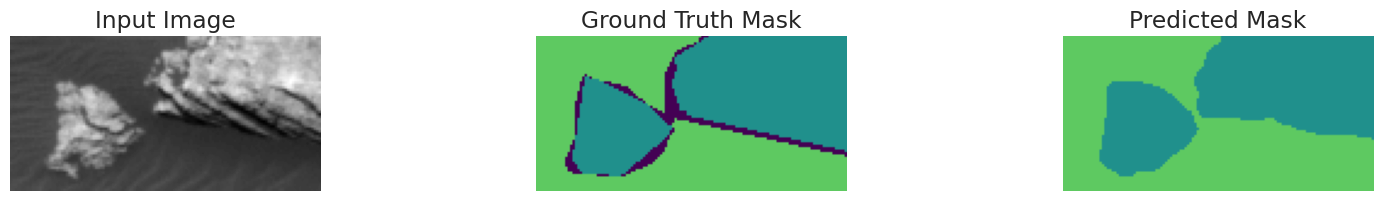

32/32 ━━━━━━━━━━━━━━━━━━━━ 96s 3s/step - accuracy: 0.7157 - loss: 0.1498 - mean_iou: 0.8620 - val_accuracy: 0.6874 - val_loss: 0.3565 - val_mean_iou: 0.6402 - learning_rate: 1.0000e-05
SCCE weight: 0.4671 - dice weight: 0.1316 - boundary weight: 0.4013
Epoch 102/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 95s 3s/step - accuracy: 0.7135 - loss: 0.1419 - mean_iou: 0.8769 - val_accuracy: 0.6872 - val_loss: 0.3578 - val_mean_iou: 0.6396 - learning_rate: 1.0000e-05
SCCE weight: 0.4675 - dice weight: 0.1298 - boundary weight: 0.4026
Epoch 103/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 95s 3s/step - accuracy: 0.7144 - loss: 0.1447 - mean_iou: 0.8638 - val_accuracy: 0.6868 - val_loss: 0.3571 - val_mean_iou: 0.6390 - learning_rate: 1.0000e-05
SCCE weight: 0.4680 - dice weight: 0.1281 - boundary weight: 0.4040
Epoch 104/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 95s 3s/step - accuracy: 0.7176 - loss: 0.1375 - mean_iou: 0.8760 - val_accuracy: 0.6867 - val_loss: 0.3557 - val_mean_iou: 0.6392 - learning_rate: 1.0000e-05
SCCE weight: 0

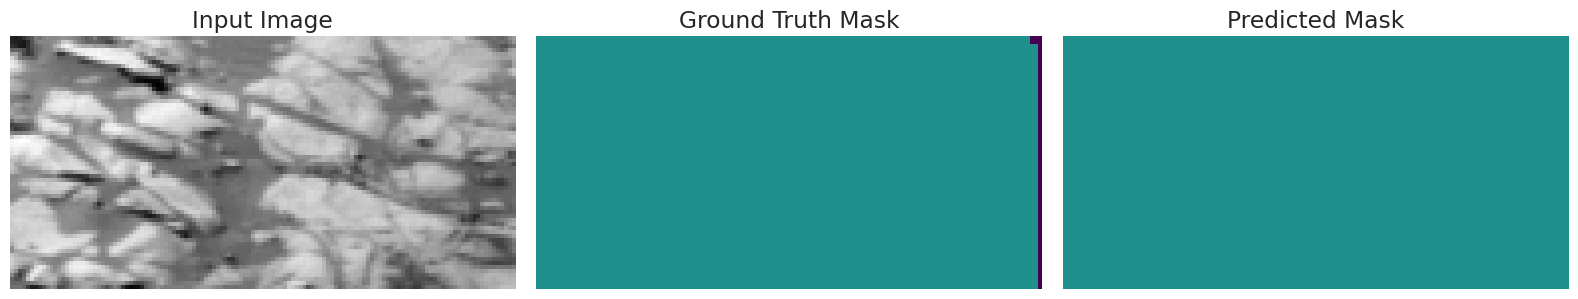

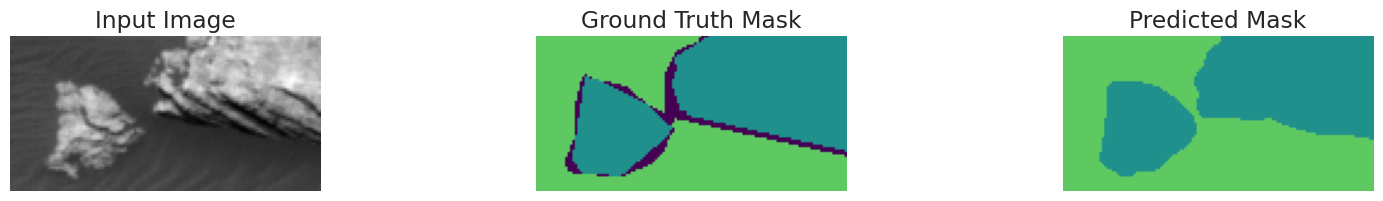

32/32 ━━━━━━━━━━━━━━━━━━━━ 97s 3s/step - accuracy: 0.7133 - loss: 0.1483 - mean_iou: 0.8533 - val_accuracy: 0.6871 - val_loss: 0.3565 - val_mean_iou: 0.6400 - learning_rate: 1.0000e-06
SCCE weight: 0.4693 - dice weight: 0.1229 - boundary weight: 0.4078
Epoch 107/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 95s 3s/step - accuracy: 0.7152 - loss: 0.1414 - mean_iou: 0.8655 - val_accuracy: 0.6871 - val_loss: 0.3564 - val_mean_iou: 0.6399 - learning_rate: 1.0000e-06
SCCE weight: 0.4697 - dice weight: 0.1212 - boundary weight: 0.4091
Epoch 108/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 95s 3s/step - accuracy: 0.7172 - loss: 0.1487 - mean_iou: 0.8681 - val_accuracy: 0.6872 - val_loss: 0.3565 - val_mean_iou: 0.6401 - learning_rate: 1.0000e-06
SCCE weight: 0.4701 - dice weight: 0.1195 - boundary weight: 0.4104
Epoch 109/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 95s 3s/step - accuracy: 0.7131 - loss: 0.1475 - mean_iou: 0.8484 - val_accuracy: 0.6873 - val_loss: 0.3571 - val_mean_iou: 0.6402 - learning_rate: 1.0000e-06
SCCE weight: 0

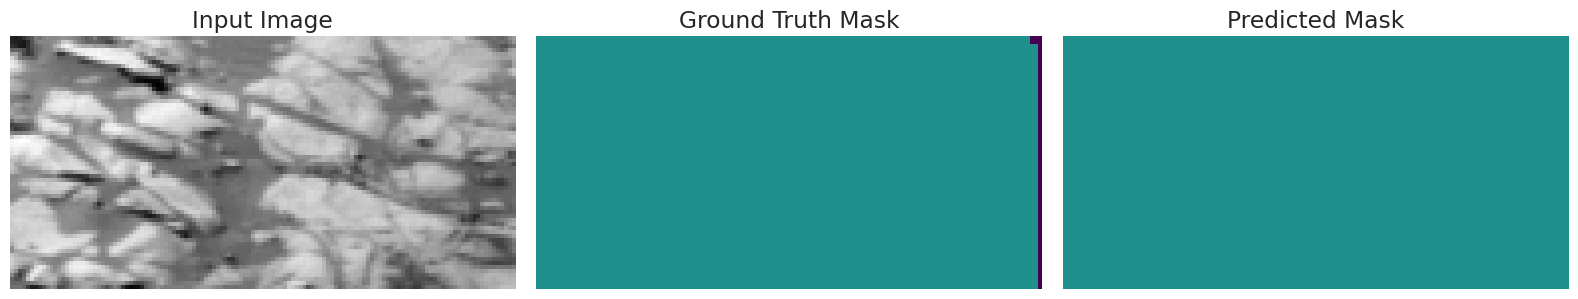

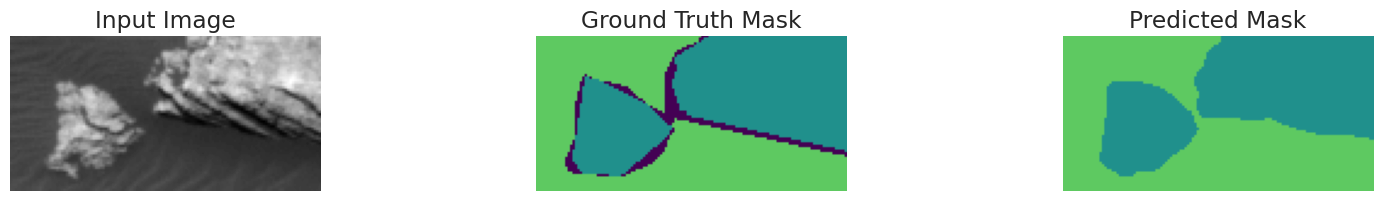

32/32 ━━━━━━━━━━━━━━━━━━━━ 97s 3s/step - accuracy: 0.7153 - loss: 0.1418 - mean_iou: 0.8666 - val_accuracy: 0.6874 - val_loss: 0.3564 - val_mean_iou: 0.6405 - learning_rate: 1.0000e-06
SCCE weight: 0.4714 - dice weight: 0.1145 - boundary weight: 0.4141
Epoch 112/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 95s 3s/step - accuracy: 0.7152 - loss: 0.1407 - mean_iou: 0.8697 - val_accuracy: 0.6873 - val_loss: 0.3556 - val_mean_iou: 0.6403 - learning_rate: 1.0000e-06
SCCE weight: 0.4718 - dice weight: 0.1128 - boundary weight: 0.4154
Epoch 113/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 96s 3s/step - accuracy: 0.7127 - loss: 0.1372 - mean_iou: 0.8640 - val_accuracy: 0.6875 - val_loss: 0.3565 - val_mean_iou: 0.6406 - learning_rate: 1.0000e-06
SCCE weight: 0.4722 - dice weight: 0.1112 - boundary weight: 0.4166
Epoch 114/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 95s 3s/step - accuracy: 0.7156 - loss: 0.1500 - mean_iou: 0.8550 - val_accuracy: 0.6874 - val_loss: 0.3566 - val_mean_iou: 0.6404 - learning_rate: 1.0000e-06
SCCE weight: 0

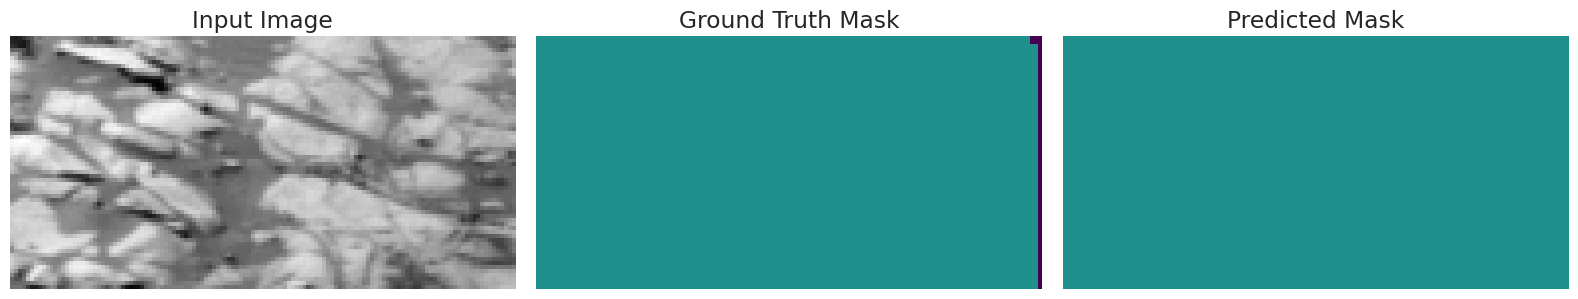

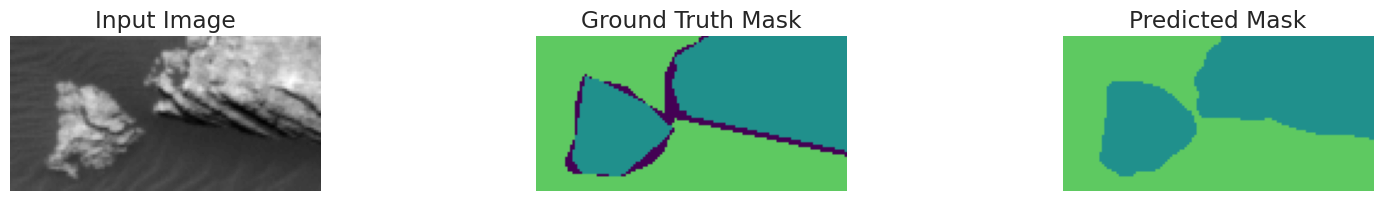

32/32 ━━━━━━━━━━━━━━━━━━━━ 96s 3s/step - accuracy: 0.7143 - loss: 0.1449 - mean_iou: 0.8831 - val_accuracy: 0.6874 - val_loss: 0.3569 - val_mean_iou: 0.6403 - learning_rate: 1.0000e-06
SCCE weight: 0.4734 - dice weight: 0.1063 - boundary weight: 0.4203
Epoch 117/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 96s 3s/step - accuracy: 0.7127 - loss: 0.1462 - mean_iou: 0.8581 - val_accuracy: 0.6875 - val_loss: 0.3567 - val_mean_iou: 0.6404 - learning_rate: 1.0000e-06
SCCE weight: 0.4738 - dice weight: 0.1047 - boundary weight: 0.4215
Epoch 118/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 95s 3s/step - accuracy: 0.7152 - loss: 0.1491 - mean_iou: 0.8765 - val_accuracy: 0.6875 - val_loss: 0.3564 - val_mean_iou: 0.6404 - learning_rate: 1.0000e-06
SCCE weight: 0.4742 - dice weight: 0.1031 - boundary weight: 0.4226
Epoch 119/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 96s 3s/step - accuracy: 0.7112 - loss: 0.1512 - mean_iou: 0.8593 - val_accuracy: 0.6875 - val_loss: 0.3566 - val_mean_iou: 0.6405 - learning_rate: 1.0000e-06
SCCE weight: 0

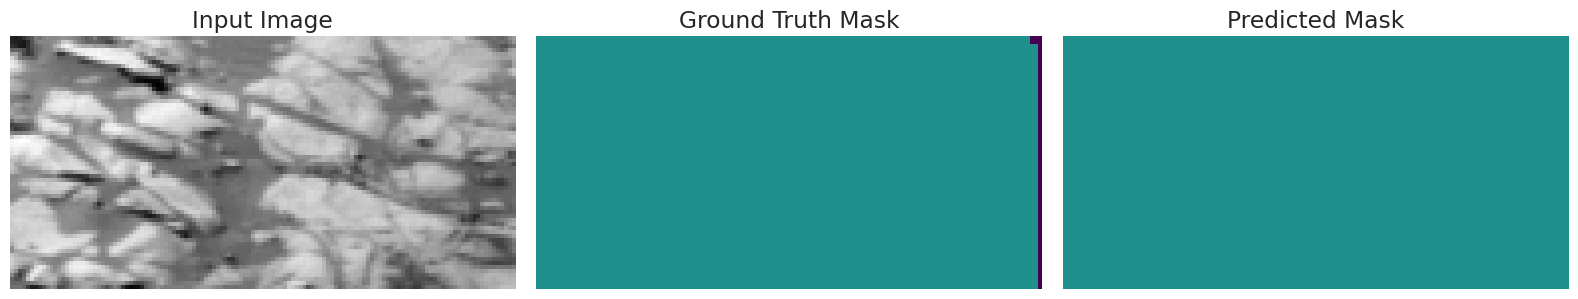

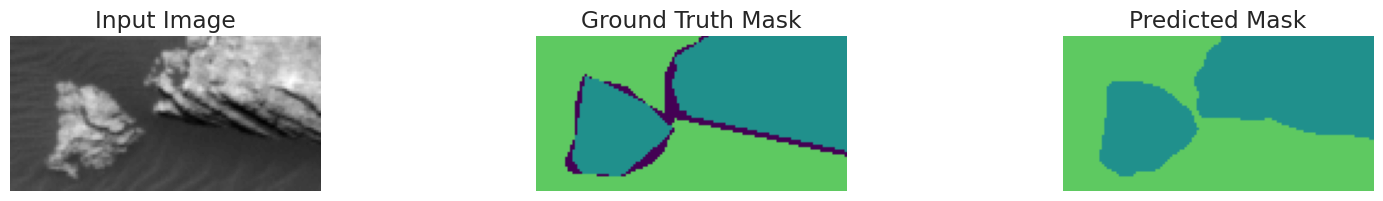

32/32 ━━━━━━━━━━━━━━━━━━━━ 96s 3s/step - accuracy: 0.7133 - loss: 0.1503 - mean_iou: 0.8608 - val_accuracy: 0.6875 - val_loss: 0.3570 - val_mean_iou: 0.6405 - learning_rate: 1.0000e-07
SCCE weight: 0.4754 - dice weight: 0.0984 - boundary weight: 0.4262
Epoch 122/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 96s 3s/step - accuracy: 0.7160 - loss: 0.1401 - mean_iou: 0.8686 - val_accuracy: 0.6876 - val_loss: 0.3570 - val_mean_iou: 0.6407 - learning_rate: 1.0000e-07
SCCE weight: 0.4758 - dice weight: 0.0969 - boundary weight: 0.4273
Epoch 123/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 95s 3s/step - accuracy: 0.7183 - loss: 0.1527 - mean_iou: 0.8485 - val_accuracy: 0.6875 - val_loss: 0.3569 - val_mean_iou: 0.6405 - learning_rate: 1.0000e-07
SCCE weight: 0.4762 - dice weight: 0.0954 - boundary weight: 0.4285
Epoch 124/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 95s 3s/step - accuracy: 0.7152 - loss: 0.1410 - mean_iou: 0.8805 - val_accuracy: 0.6876 - val_loss: 0.3576 - val_mean_iou: 0.6407 - learning_rate: 1.0000e-07
Final validati

In [30]:
# Train the model
history = model.fit( 
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[early_stopping, learning_rate, epoch_tracker, viz_callback],
    verbose=1
).history

# Calculate and print the final validation accuracy
final_val_meanIoU = round(max(history['val_mean_iou'])* 100, 2)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

# Save the trained model to a file 
timestep_str = datetime.now().strftime("%y%m%d_%H%M%S")
model_filename = f"model_{timestep_str}.keras"
model.save(model_filename)

print(f"Model saved to {model_filename}")

#del model

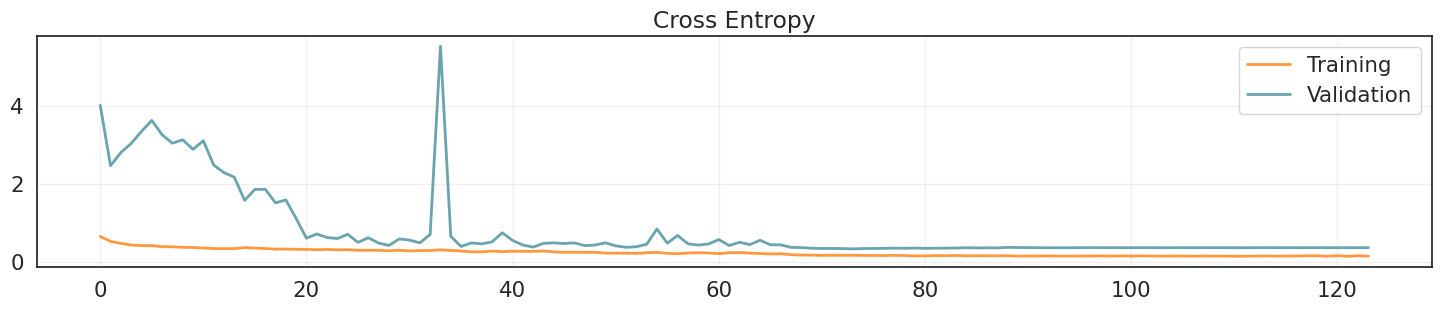

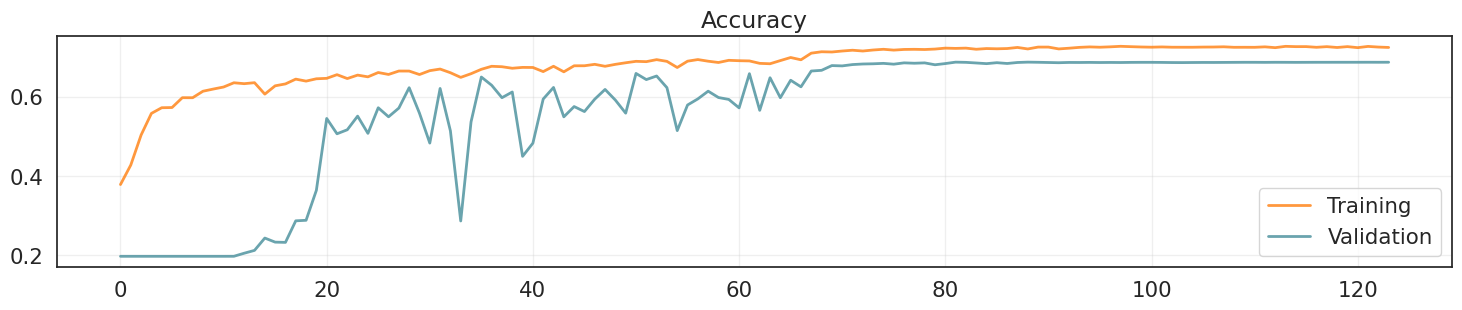

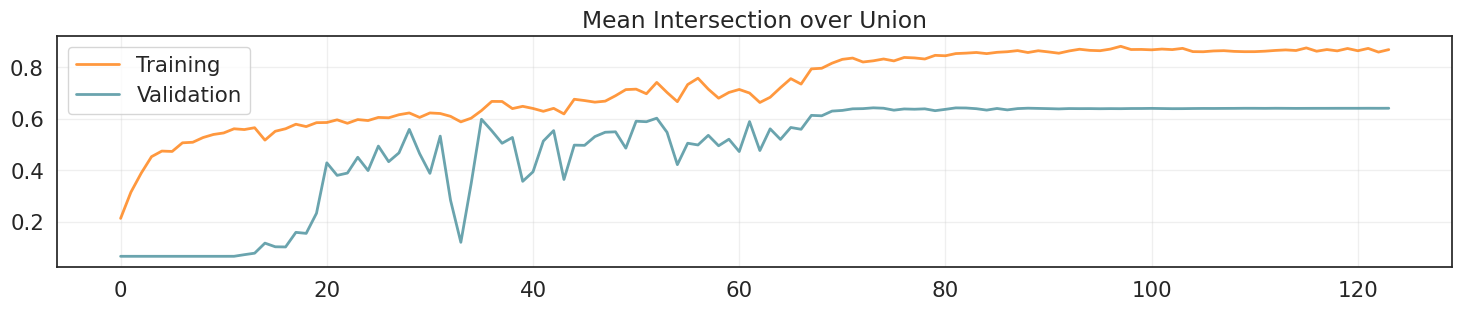

In [31]:
# Plot and display training and validation loss
plt.figure(figsize=(18, 3))
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_loss'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Cross Entropy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation accuracy
plt.figure(figsize=(18, 3))
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation mean IoU
plt.figure(figsize=(18, 3))
plt.plot(history['mean_iou'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_mean_iou'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Mean Intersection over Union')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## 🔮 Predictions on the Test Set

In [32]:
# If model_filename is not defined, load the most recent model from Google Drive
if "model_filename" not in globals() or model_filename is None:
    files = [f for f in os.listdir('.') if os.path.isfile(f) and f.startswith('model_') and f.endswith('.keras')]
    files.sort(key=lambda x: os.path.getmtime(x), reverse=True)
    if files:
        model_filename = files[0]
    else:
        raise FileNotFoundError("No model files found in the current directory.")

In [33]:
'''
model = tfk.models.load_model(model_filename, compile=False)
print(f"Model loaded from {model_filename}")
'''

'\nmodel = tfk.models.load_model(model_filename, compile=False)\nprint(f"Model loaded from {model_filename}")\n'

In [34]:
preds = model.predict(X_test)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 214s 602ms/step
Predictions shape: (10022, 64, 128)


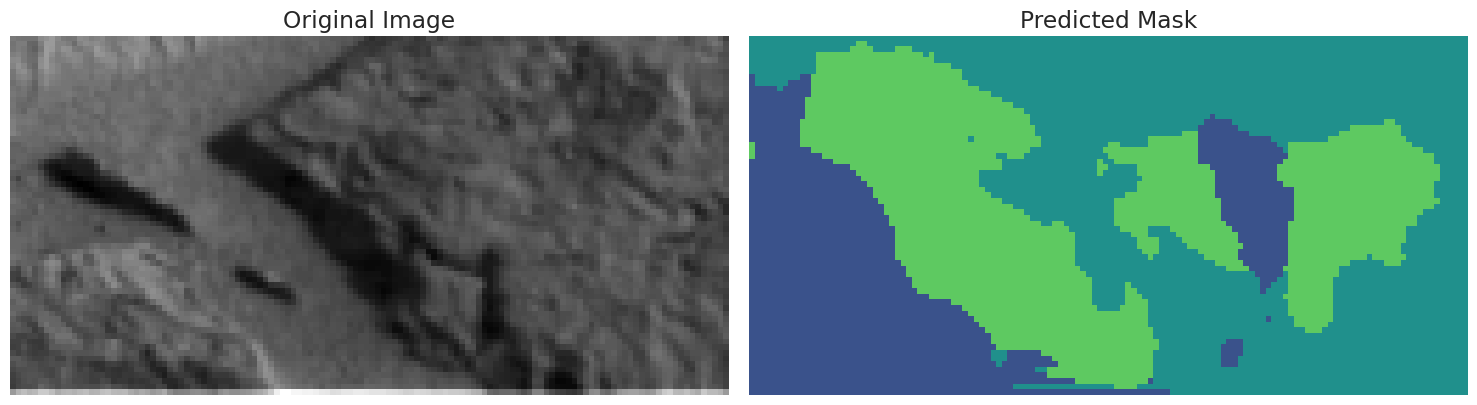

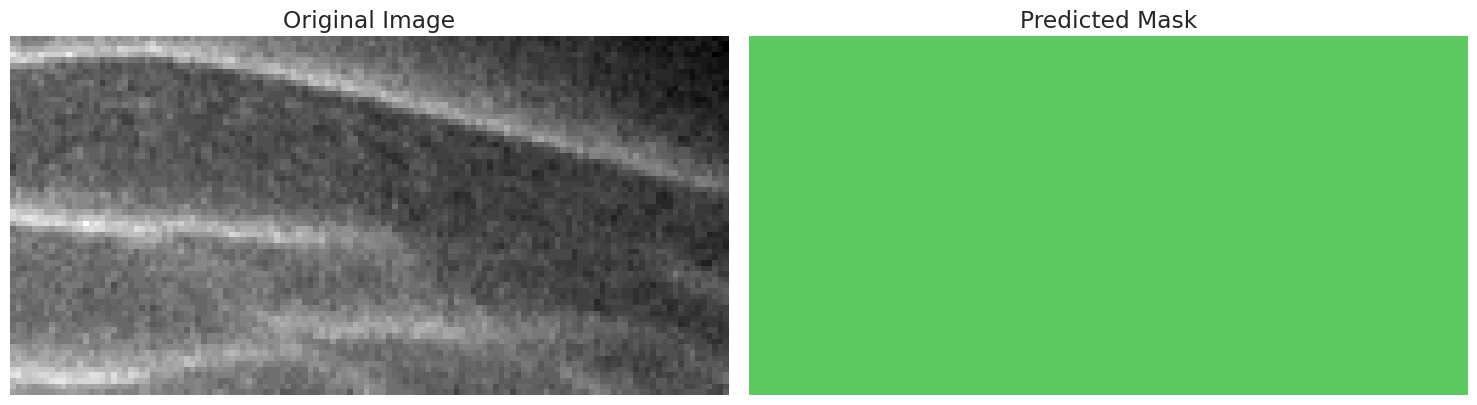

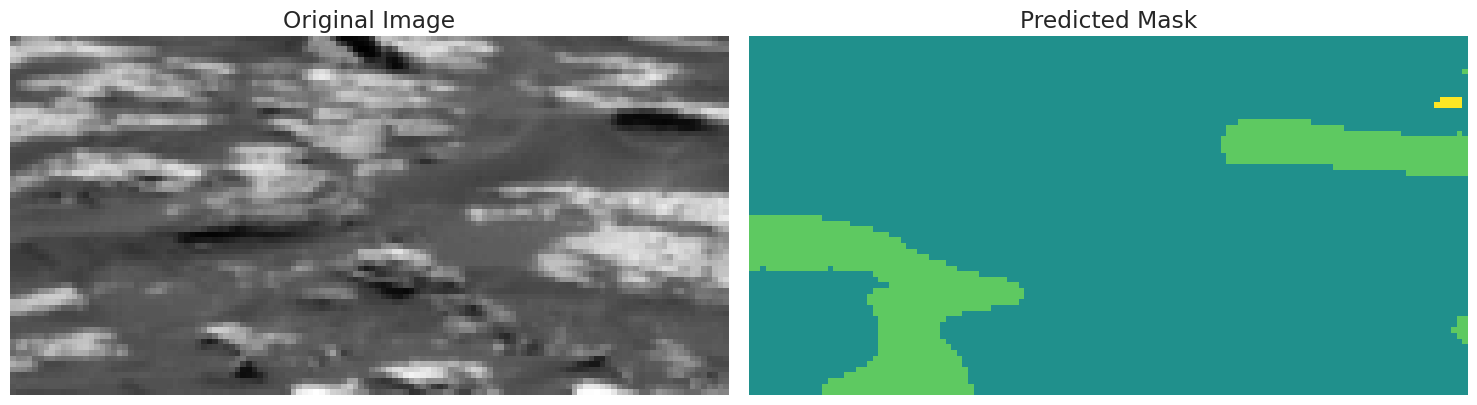

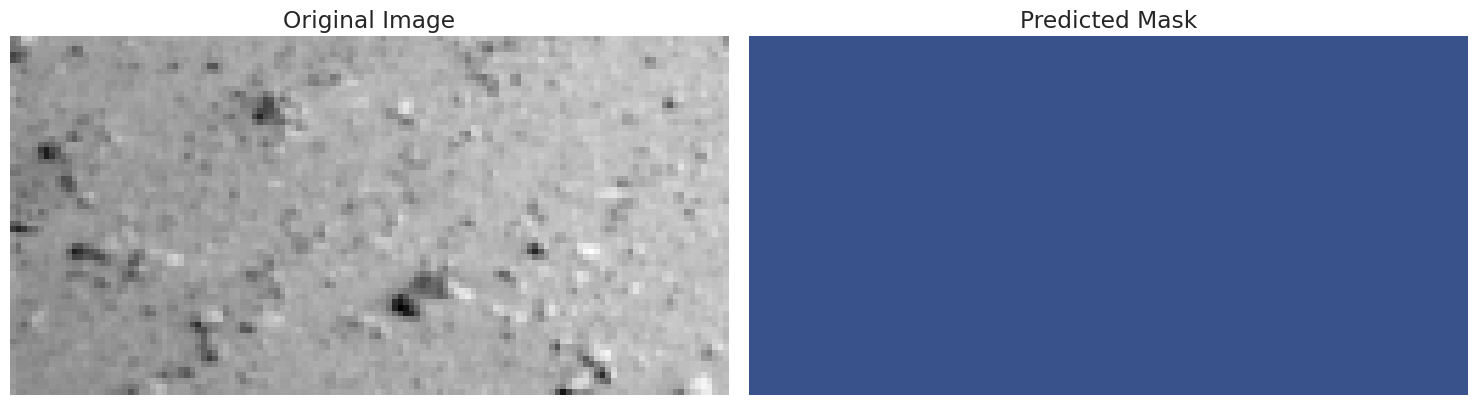

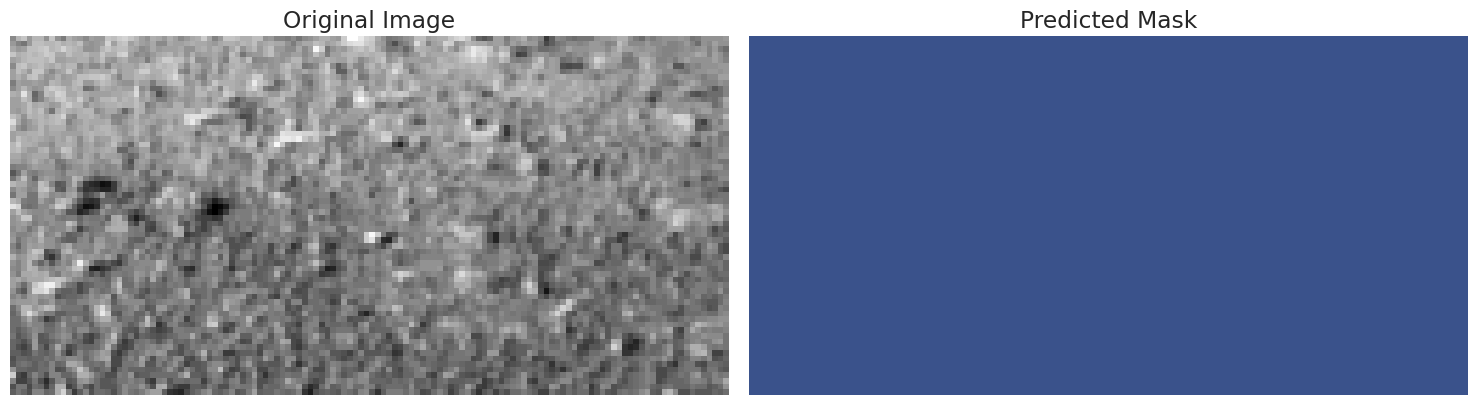

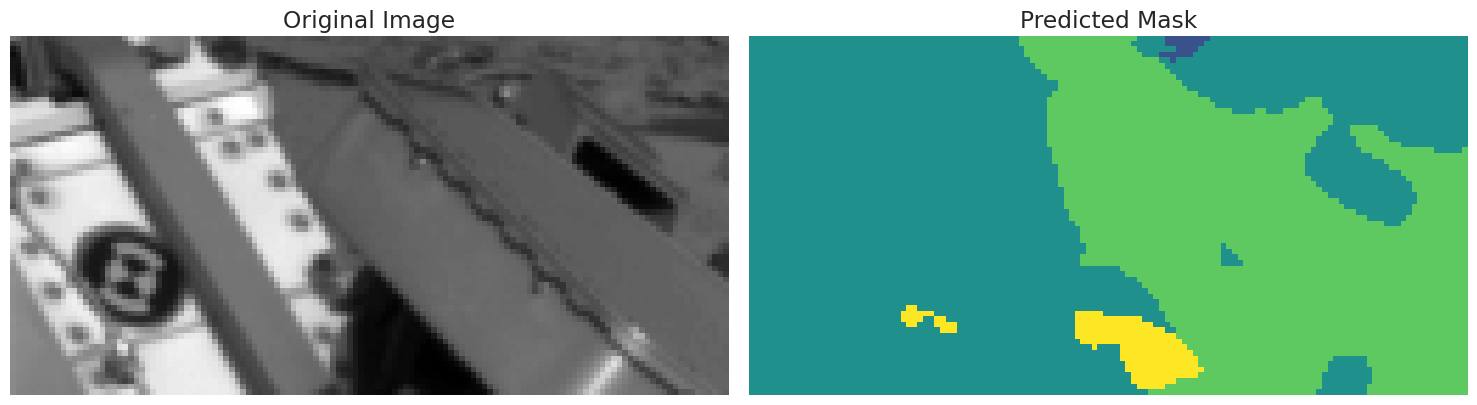

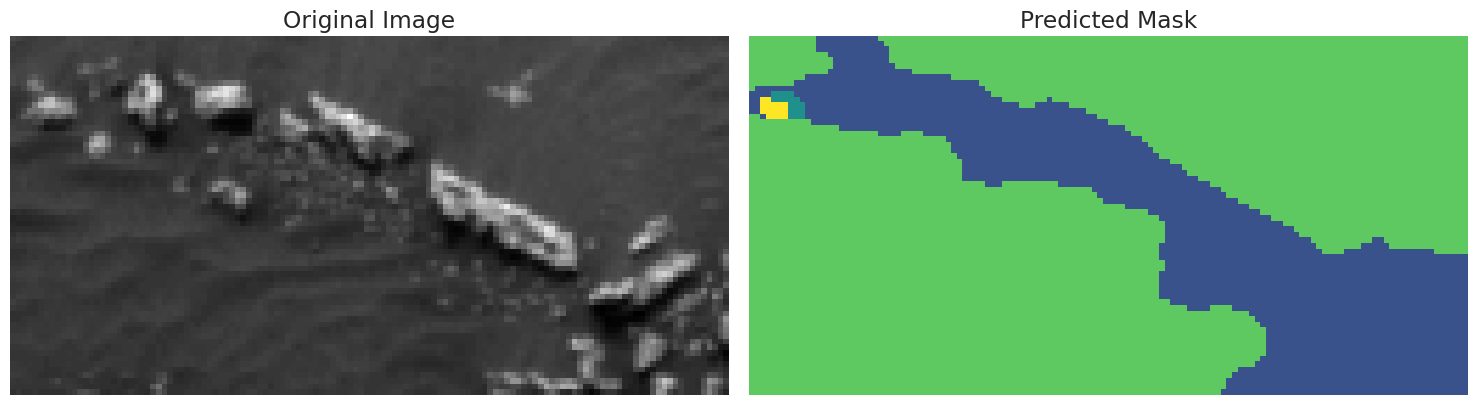

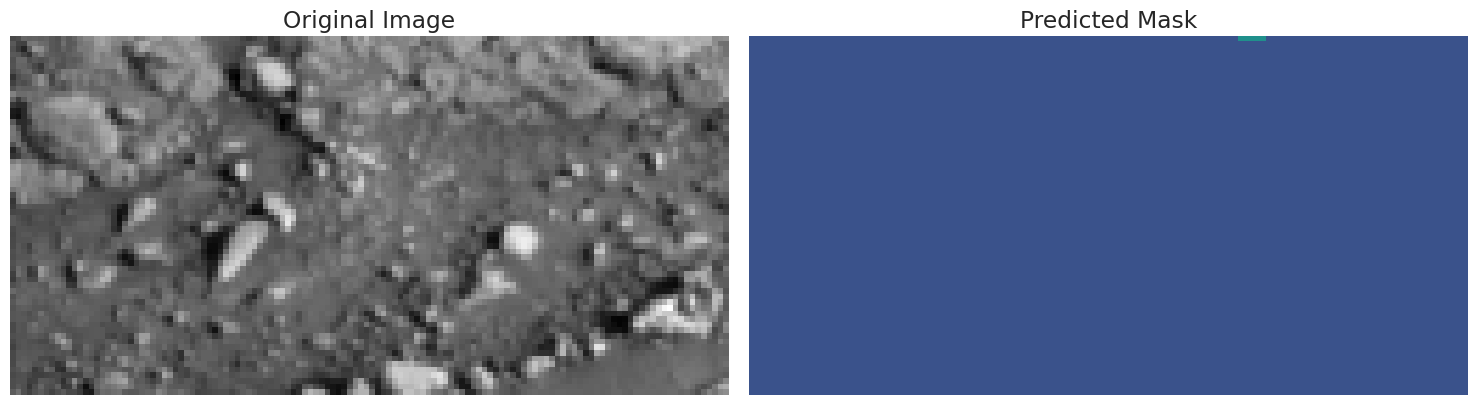

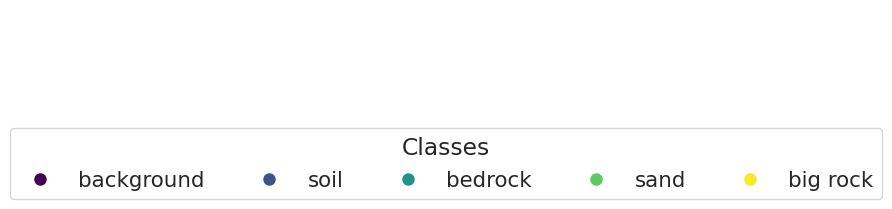

In [35]:
# Plot some predictions 
num_samples = 8
# Only take the first `num_samples` from X_test and preds
images = X_test[:num_samples]
predictions = preds[:num_samples]

# Adjust the number of classes to match the actual classes in the predictions (excluding 0)
num_classes = len(classes) # Excluding background

# Create colormap based on the number of classes
colormap = create_segmentation_colormap(num_classes)

# Create a list to store the handles for the legend (only once)
handles = []

for i in range(num_samples):
    # Get the i-th image and its prediction
    image = images[i]
    predicted_mask = predictions[i]

    # Create figure with subplots
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Plot original image
    axes[0].set_title("Original Image")
    axes[0].imshow(image, cmap='gray')
    axes[0].axis('off')

    # Plot predicted mask
    axes[1].set_title("Predicted Mask")
    colored_pred = apply_colormap(predicted_mask, colormap)
    axes[1].imshow(colored_pred)
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()
    plt.close()

# After all images have been plotted, add the legend once
# We collect handles for the legend here, only once
for label_idx in category_map: 
    color = colormap[label_idx]  # Use array indexing, subtracting 1 to account for class 0 exclusion
    handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=classes[label_idx]))

# Create a single legend displayed at the bottom
fig, ax = plt.subplots(figsize=(10, 2))  # Make the figure wide enough for a horizontal legend
ax.legend(handles=handles, loc='center', bbox_to_anchor=(0.5, 0), title="Classes", ncol=len(category_map))
ax.axis('off')
plt.show()

In [36]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [37]:
# Create the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)

In [38]:
del model